# PypeIt Reduction

CookBook: https://pypeit.readthedocs.io/en/stable/cookbook.html

Tutorial: https://pypeit.readthedocs.io/en/stable/tutorials/kast_howto.html

Another useful notebook: https://github.com/SN-ICE/GTC_PypeIt/blob/main/pypeit_tutorial.ipynb

In [1]:
import os
import shutil
import subprocess
from pathlib import Path

import random
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from IPython.display import IFrame, display

from astropy.io import fits
from astropy import units as u
from specutils.spectra import Spectrum1D
from specutils.fitting.continuum import fit_continuum
from scipy.signal import savgol_filter

%config InlineBackend.figure_format = 'retina'
plt.rcParams["font.family"] = "P052"
plt.rcParams['mathtext.fontset'] = "cm"

In [25]:
def plot_1dspec(file):
    hdu = fits.open(file)
    wave = hdu[i].data['OPT_WAVE']
    flux = hdu[i].data['OPT_COUNTS']
    
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.plot(wave, flux, lw=3, color='k')
    
    ax.set_xlabel(r'Wavelength [$\AA$]',fontsize=17)
    ax.set_ylabel('Counts',fontsize=17)
    ax.tick_params(labelsize=16)
    plt.show()

## Initial Setup

Define the directory where to find the images and the setup (telescope + instrument).

In [2]:
data_dir = Path("OB0016/")  # where your raw data lives
setup = "gtc_osiris"
setup_type = "A"  # A for R1000B and B for R1000R
setup_dir = f"{setup}_{setup_type}"  

-- In principle, none of the things below should be changed. --

In [3]:
# collect raw science files (including STDs)
data_files = [file for file in data_dir.rglob("*.fits")]

# create reduction directory and copy files
reduc_dir = data_dir.with_name("REDUC_" + data_dir.name)
reduc_data = reduc_dir / "data"
print(f"Creating directory '{reduc_data}' (skipped if already exists).\n")
reduc_data.mkdir(parents=True, exist_ok=True)
reduc_files = [reduc_data / file.name for file in data_files]
for original_file, copy_file in zip(data_files, reduc_files):
    shutil.copy2(original_file, copy_file)
print(f"All files copied to '{reduc_data}'\n")

# commands to run on a terminal
print(f"In a terminal, change to your reduction directory:\ncd {reduc_dir.absolute()}\n")
print(f"Now run the initial setup:\npypeit_setup -r {reduc_data.stem} -s {setup} -c {setup_type}\n")

Creating directory 'REDUC_OB0016/data' (skipped if already exists).

All files copied to 'REDUC_OB0016/data'

In a terminal, change to your reduction directory:
cd /home/tomas/Softwares/reductions/2020lao/REDUC_OB0016

Now run the initial setup:
pypeit_setup -r data -s gtc_osiris -c A



### Check Config File

Check the file produced by `pypeit_setup` that will be used for the reduction.

You can add some of this options to the setup file to help with the reduction:
```
[reduce]
    [[findobj]]
        snr_thresh = 7.0
        find_min_max = 1200, 2000
        find_fwhm = 3.0
```

You can also change the sky subtraction:

```
[reduce]
   [[extraction]]
      boxcar_radius = 2.5  # arcsec
   [[skysub]]
      mask_by_boxcar = True
```

```
[reduce]
    [[findobj]]
        snr_thresh = 60.0
    [[extraction]]
        boxcar_radius = 1.0
    [[skysub]]
        mask_by_boxcar = True
```

In [28]:
with open(reduc_dir / setup_dir / f"{setup_dir}.pypeit", "r") as pepyit_file:
    print(pepyit_file.read())

# Auto-generated PypeIt input file using PypeIt version: 1.17.3
# UTC 2025-05-27T13:44:58.411+00:00

# User-defined execution parameters
[rdx]
    spectrograph = gtc_osiris

# Setup
setup read
Setup A:
  binning: 2,2
  decker: LongSlits1.0Arcsec
  dispname: R1000B
setup end

# Data block 
data read
 path /home/tomas/Softwares/reductions/2020lao/REDUC_OB0016/data
                                                  filename |                 frametype |                 ra |                   dec |           target | dispname |              decker | binning |              mjd |          airmass | exptime | calib | comb_id | bkg_id
     0002630701-20200802-OSIRIS-OsirisCalibrationLamp.fits |                  arc,tilt | 181.35216666666665 | -0.009326111111111111 |     ArcLamp_HgAr |   R1000B |  LongSlits1.0Arcsec |     2,2 | 59064.1029068367 | 13.3748135344195 |     3.6 |     0 |      -1 |     -1
     0002630702-20200802-OSIRIS-OsirisCalibrationLamp.fits |                  arc,tilt | 181.3521

## Run Reduction

In [5]:
print(f"Change to the setup directory just created:\ncd {reduc_dir.absolute() / setup_dir}\n")
print(f"And run the reduction (this takes a while):\nrun_pypeit {setup_dir}.pypeit -o")  # -o for overwriting

Change to the setup directory just created:
cd /home/tomas/Softwares/reductions/2020lao/REDUC_OB0016/gtc_osiris_A

And run the reduction (this takes a while):
run_pypeit gtc_osiris_A.pypeit -o


### Check Wavelength Calibration

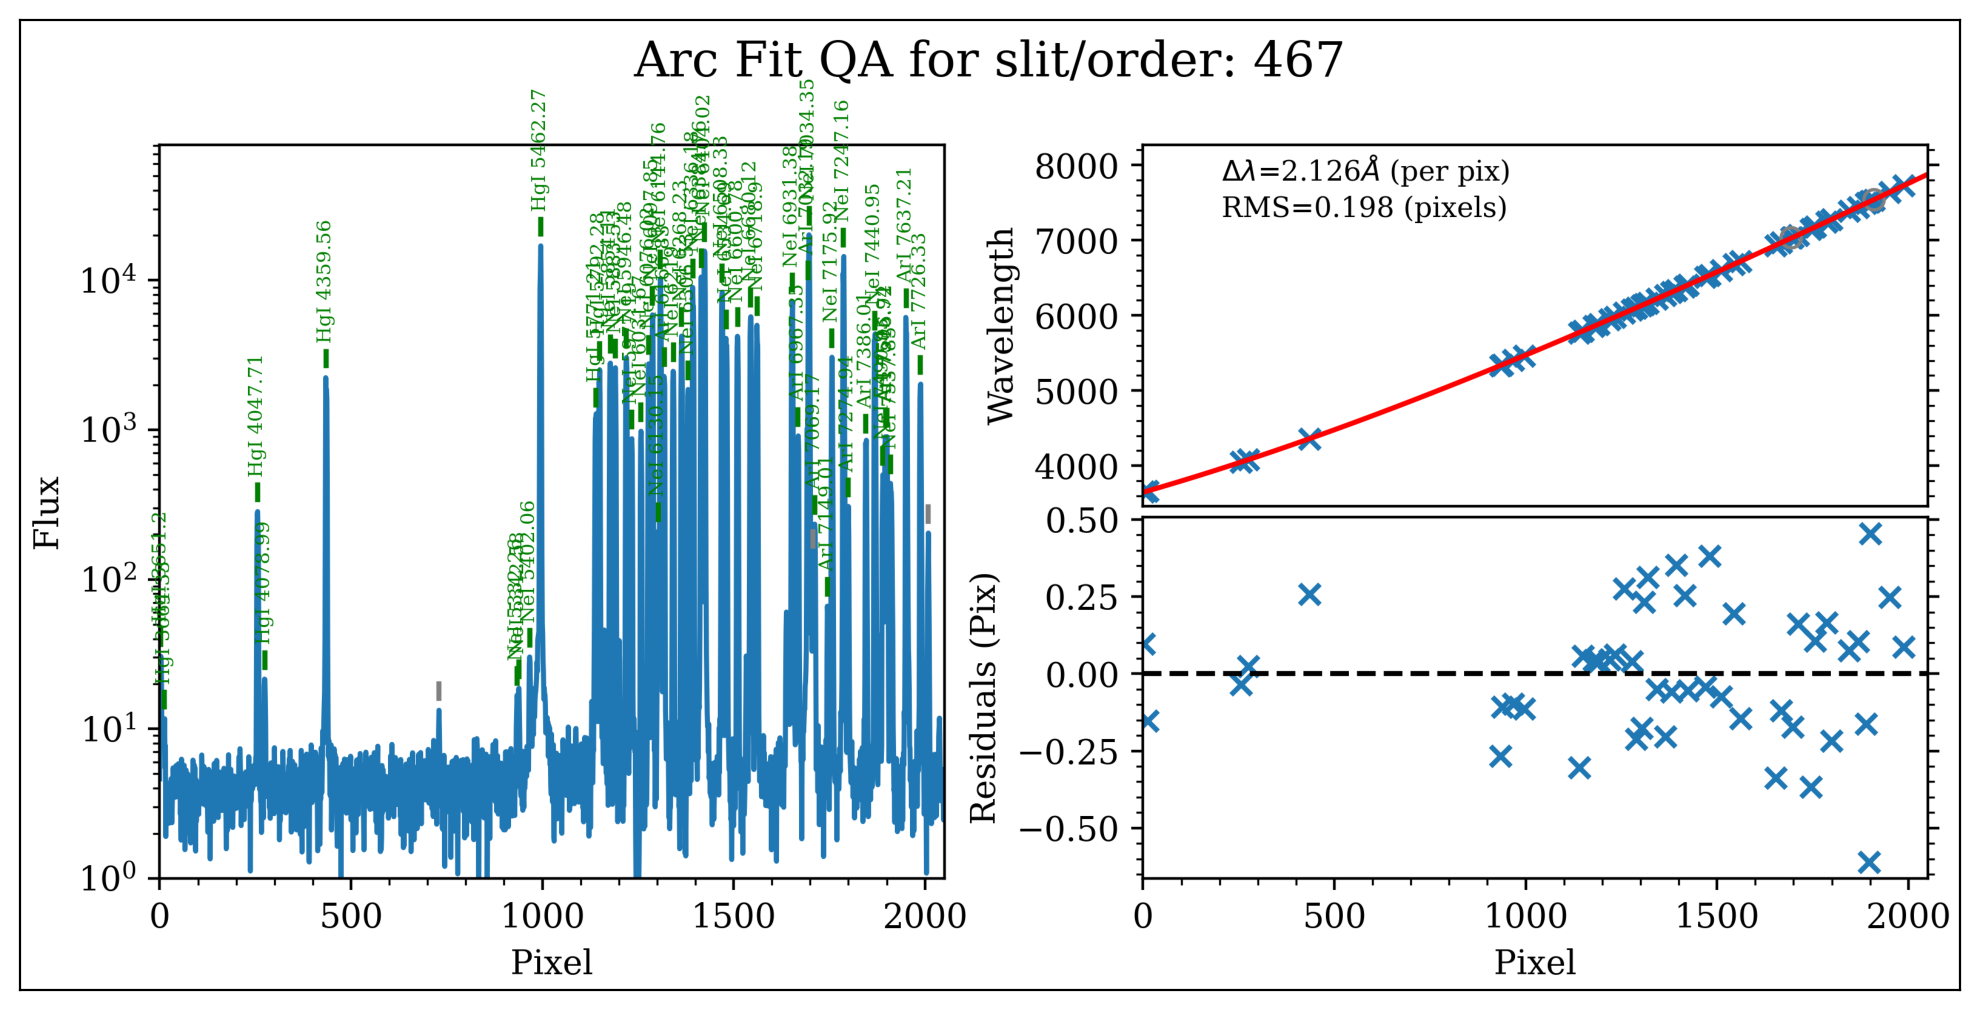

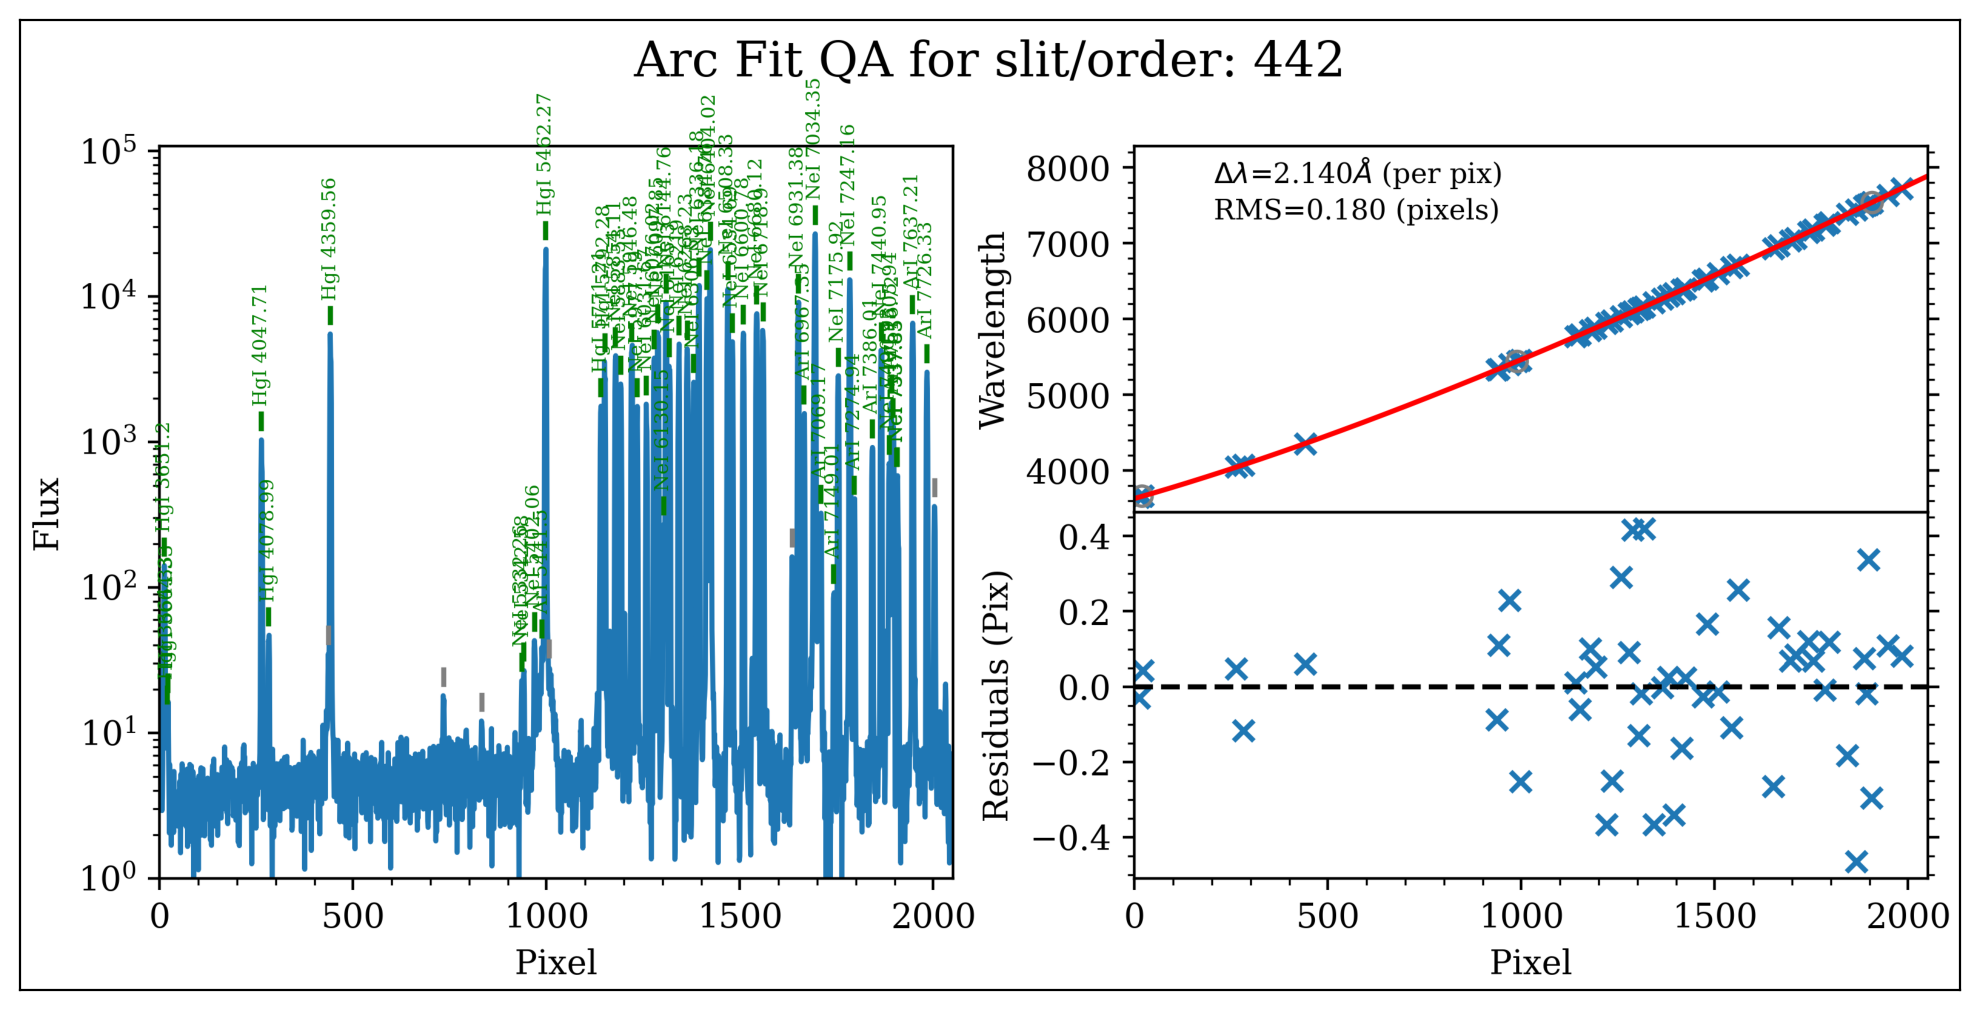

In [7]:
pngs_dir = reduc_dir / setup_dir / "QA/PNGs"
wave_calib_files = [file for file in pngs_dir.rglob("*1dfit*DET*.png")]
for file in wave_calib_files:
    fig, ax = plt.subplots(figsize=(10, 6))
    image = mpimg.imread(file)
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.show()

### Check 2D and 1D Images

Run the commands below to check the 2D and 1D extractions.

Check the `skysub-DET` tab (second one from left to right) on the ginga window.

In [33]:
def get_target_index(file):
    """Get the index with largest signal-to-noise.
    """
    hdu_list = fits.open(file)
    snr = 0.0  # signal-to-noise
    target_index = 1
    for i, hdu in enumerate(hdu_list):
        #i = len(hdu_list) - (i + 1)
        if "S2N" not in hdu.header:
            continue
        if hdu.header["S2N"] > snr:
            snr = hdu.header["S2N"]
            target_index = i
    return target_index, snr

pypeit_show_2dspec /home/tomas/Softwares/reductions/2020lao/REDUC_OB0016/gtc_osiris_A/Science/spec2d_0002631304-20200803-OSIRIS-OsirisLongSlitSpectroscopy-SPSTD_BD+33_2642_OSIRIS_20200803T221230.840.fits
pypeit_show_2dspec /home/tomas/Softwares/reductions/2020lao/REDUC_OB0016/gtc_osiris_A/Science/spec2d_0002631345-20200803-OSIRIS-OsirisLongSlitSpectroscopy-SN2020lao_OSIRIS_20200804T002019.840.fits
pypeit_show_2dspec /home/tomas/Softwares/reductions/2020lao/REDUC_OB0016/gtc_osiris_A/Science/spec2d_0002631344-20200803-OSIRIS-OsirisLongSlitSpectroscopy-SN2020lao_OSIRIS_20200803T235455.840.fits

Index of target with larget S/N (254.44857356377543): 3
pypeit_show_1dspec /home/tomas/Softwares/reductions/2020lao/REDUC_OB0016/gtc_osiris_A/Science/spec1d_0002631304-20200803-OSIRIS-OsirisLongSlitSpectroscopy-SPSTD_BD+33_2642_OSIRIS_20200803T221230.840.fits --exten 3
Index of target with larget S/N (244.58550472916116): 1
pypeit_show_1dspec /home/tomas/Softwares/reductions/2020lao/REDUC_OB0016/gt

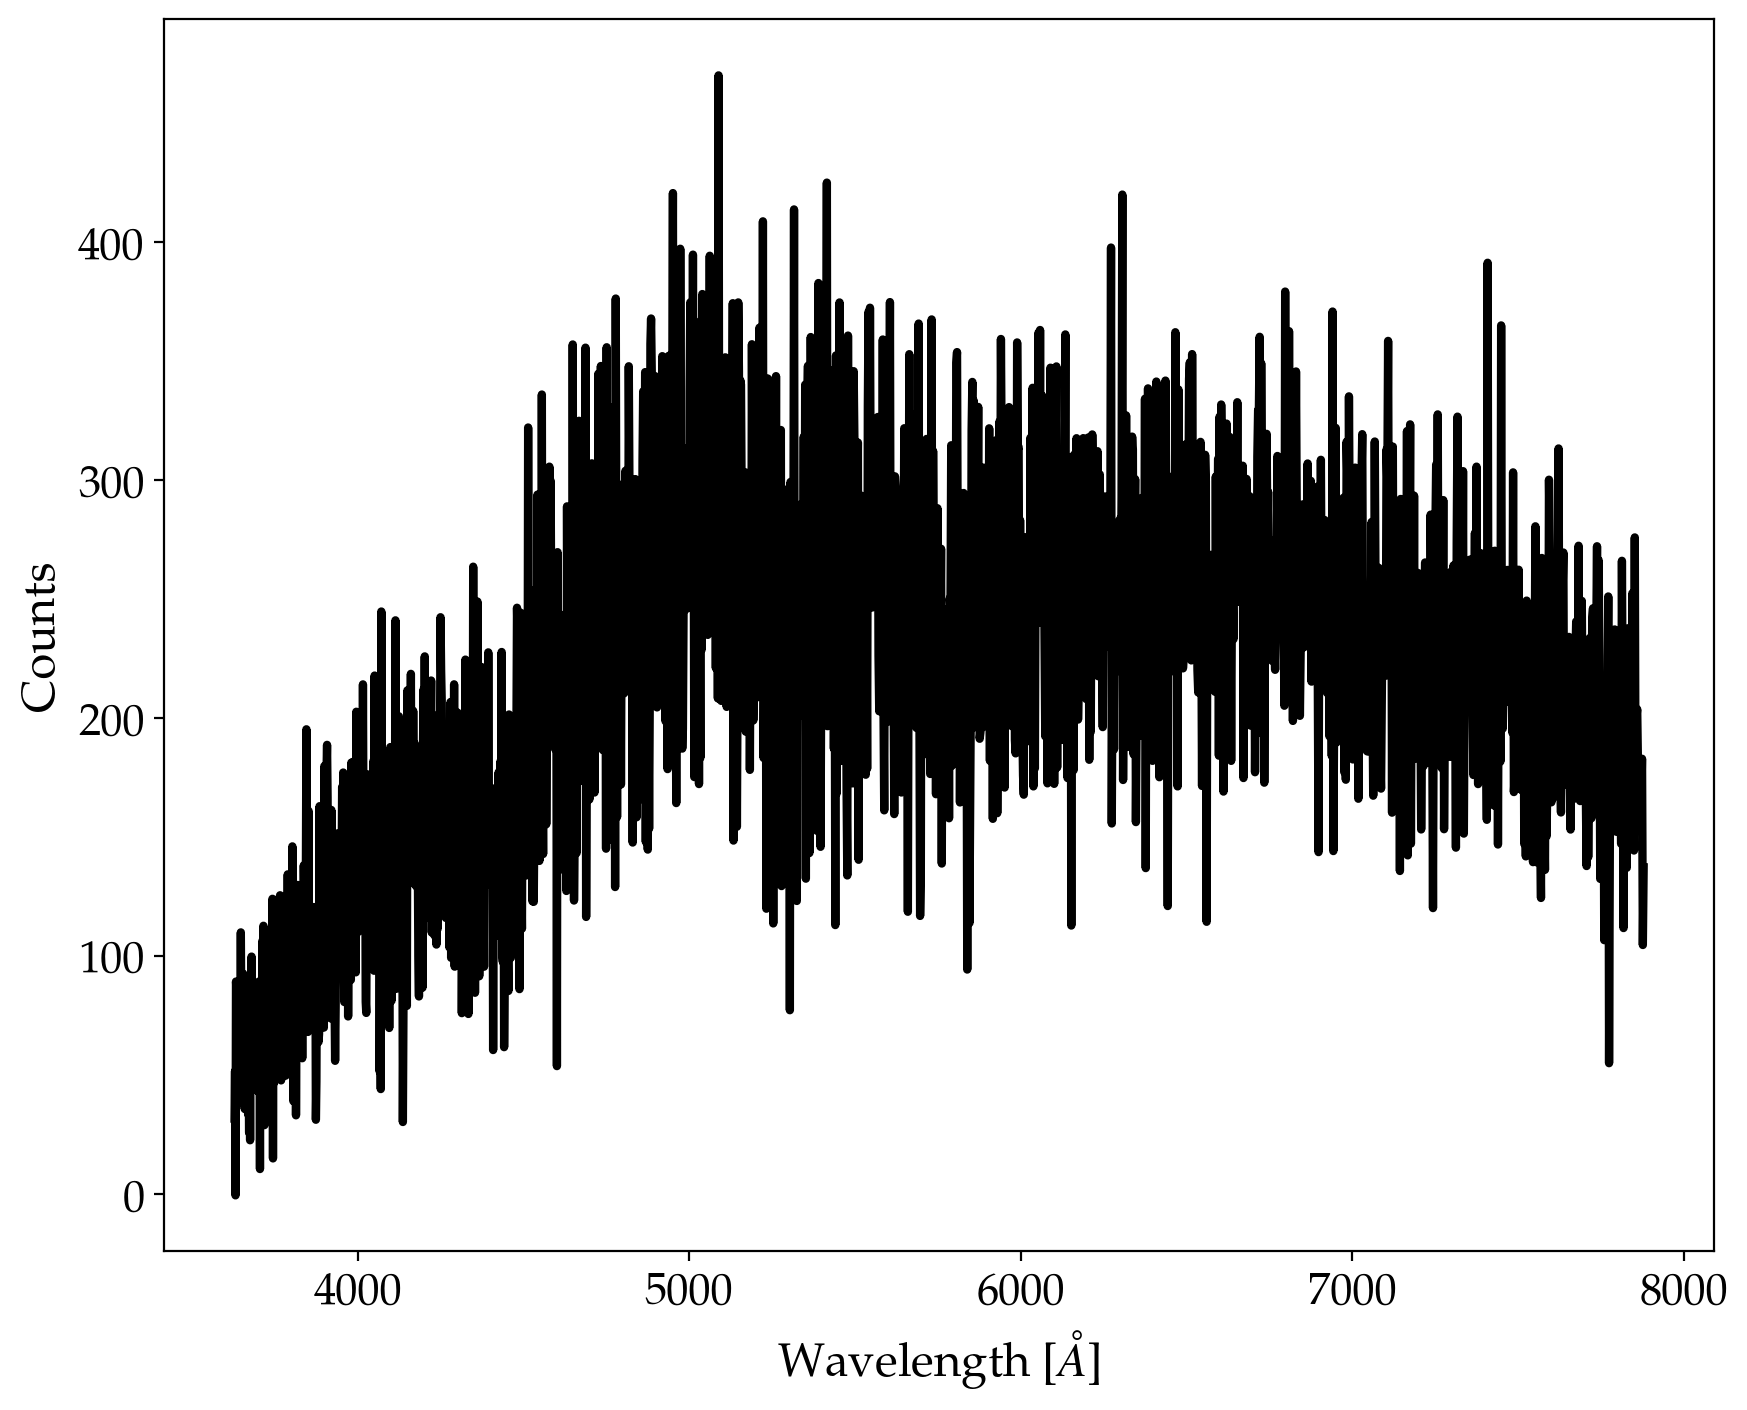

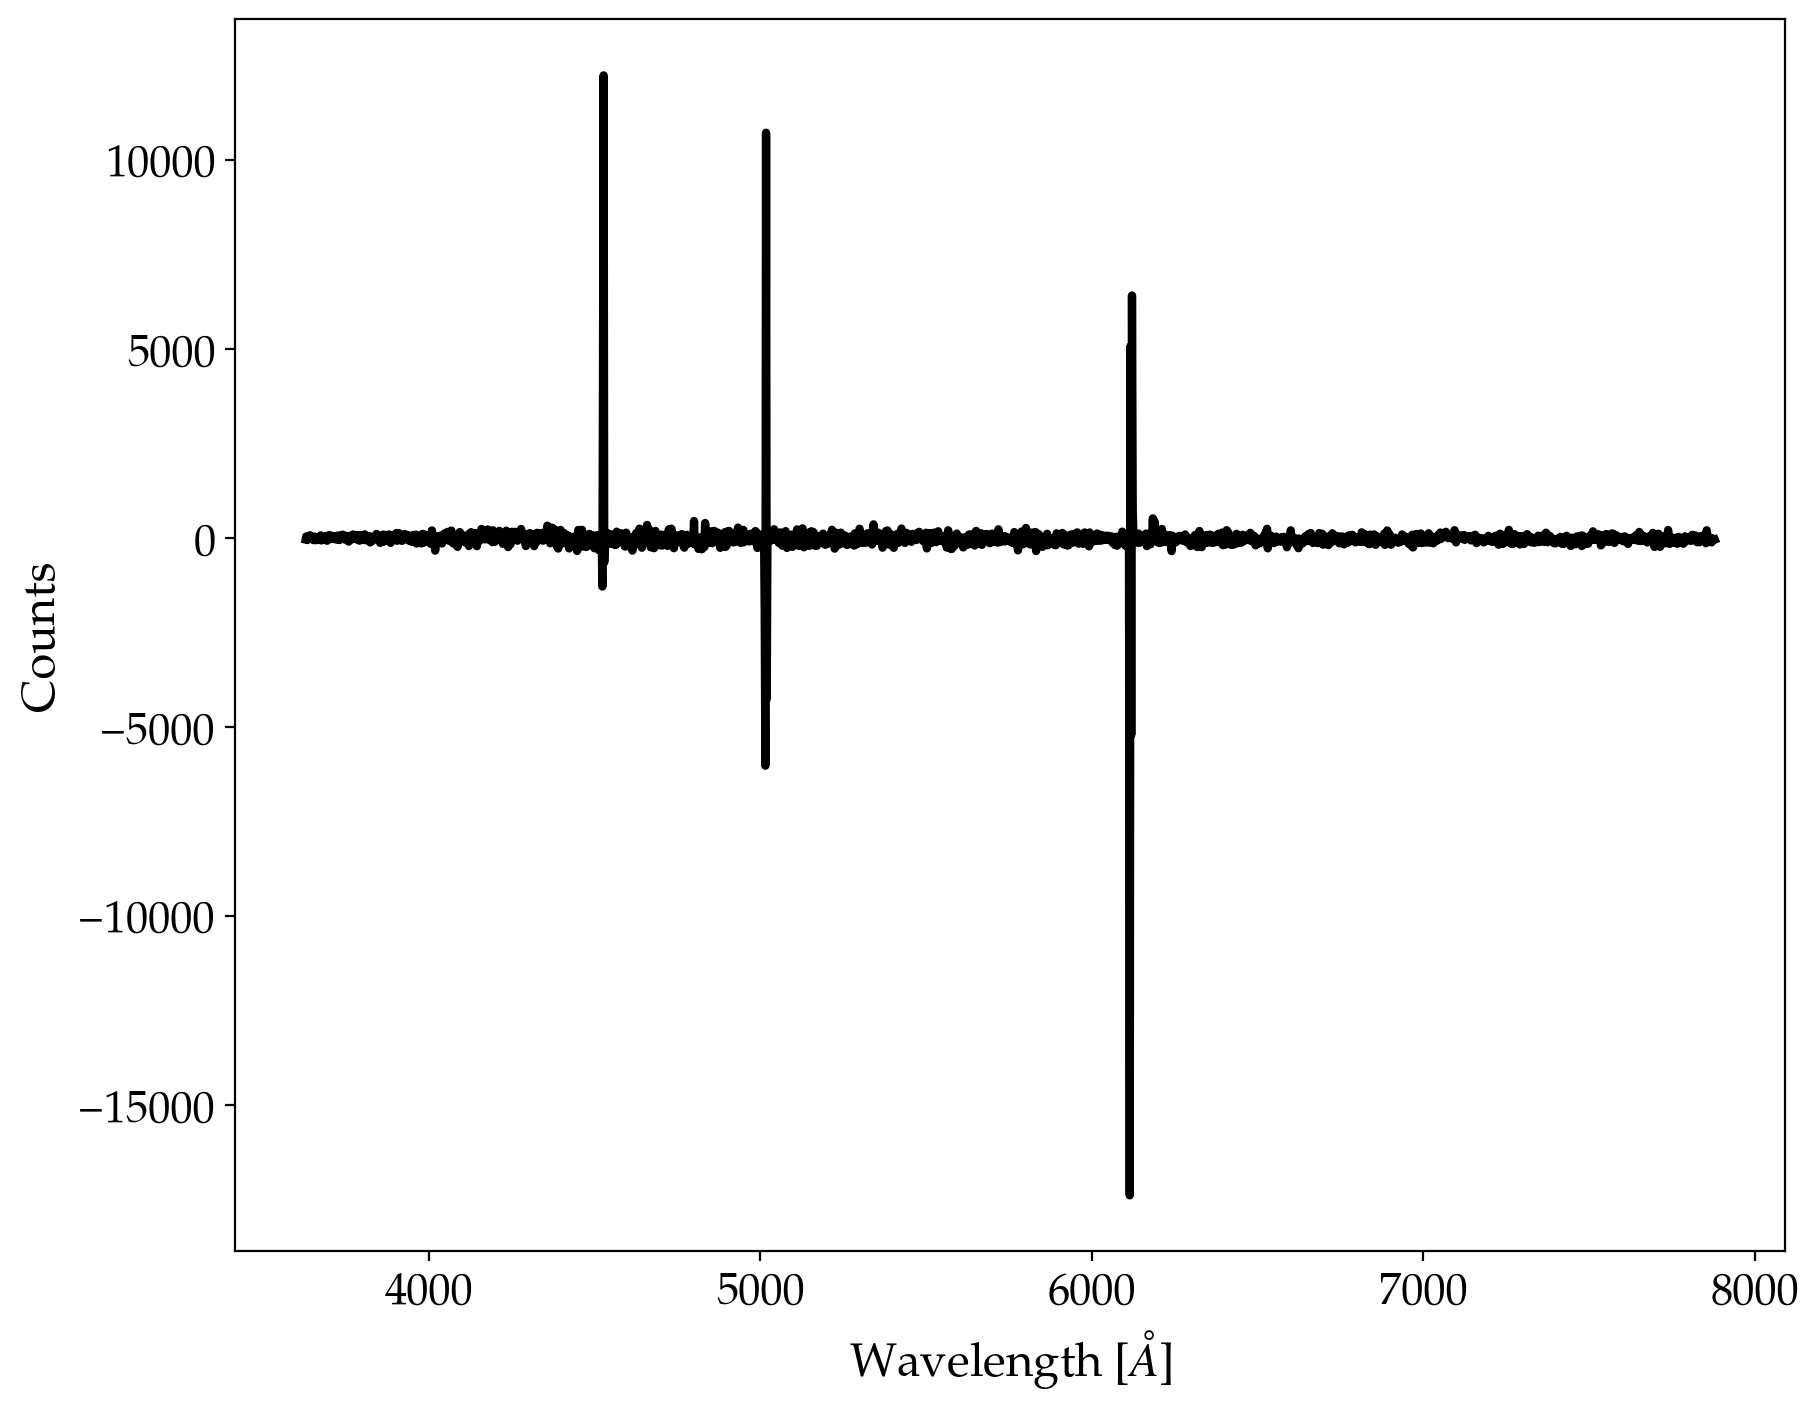

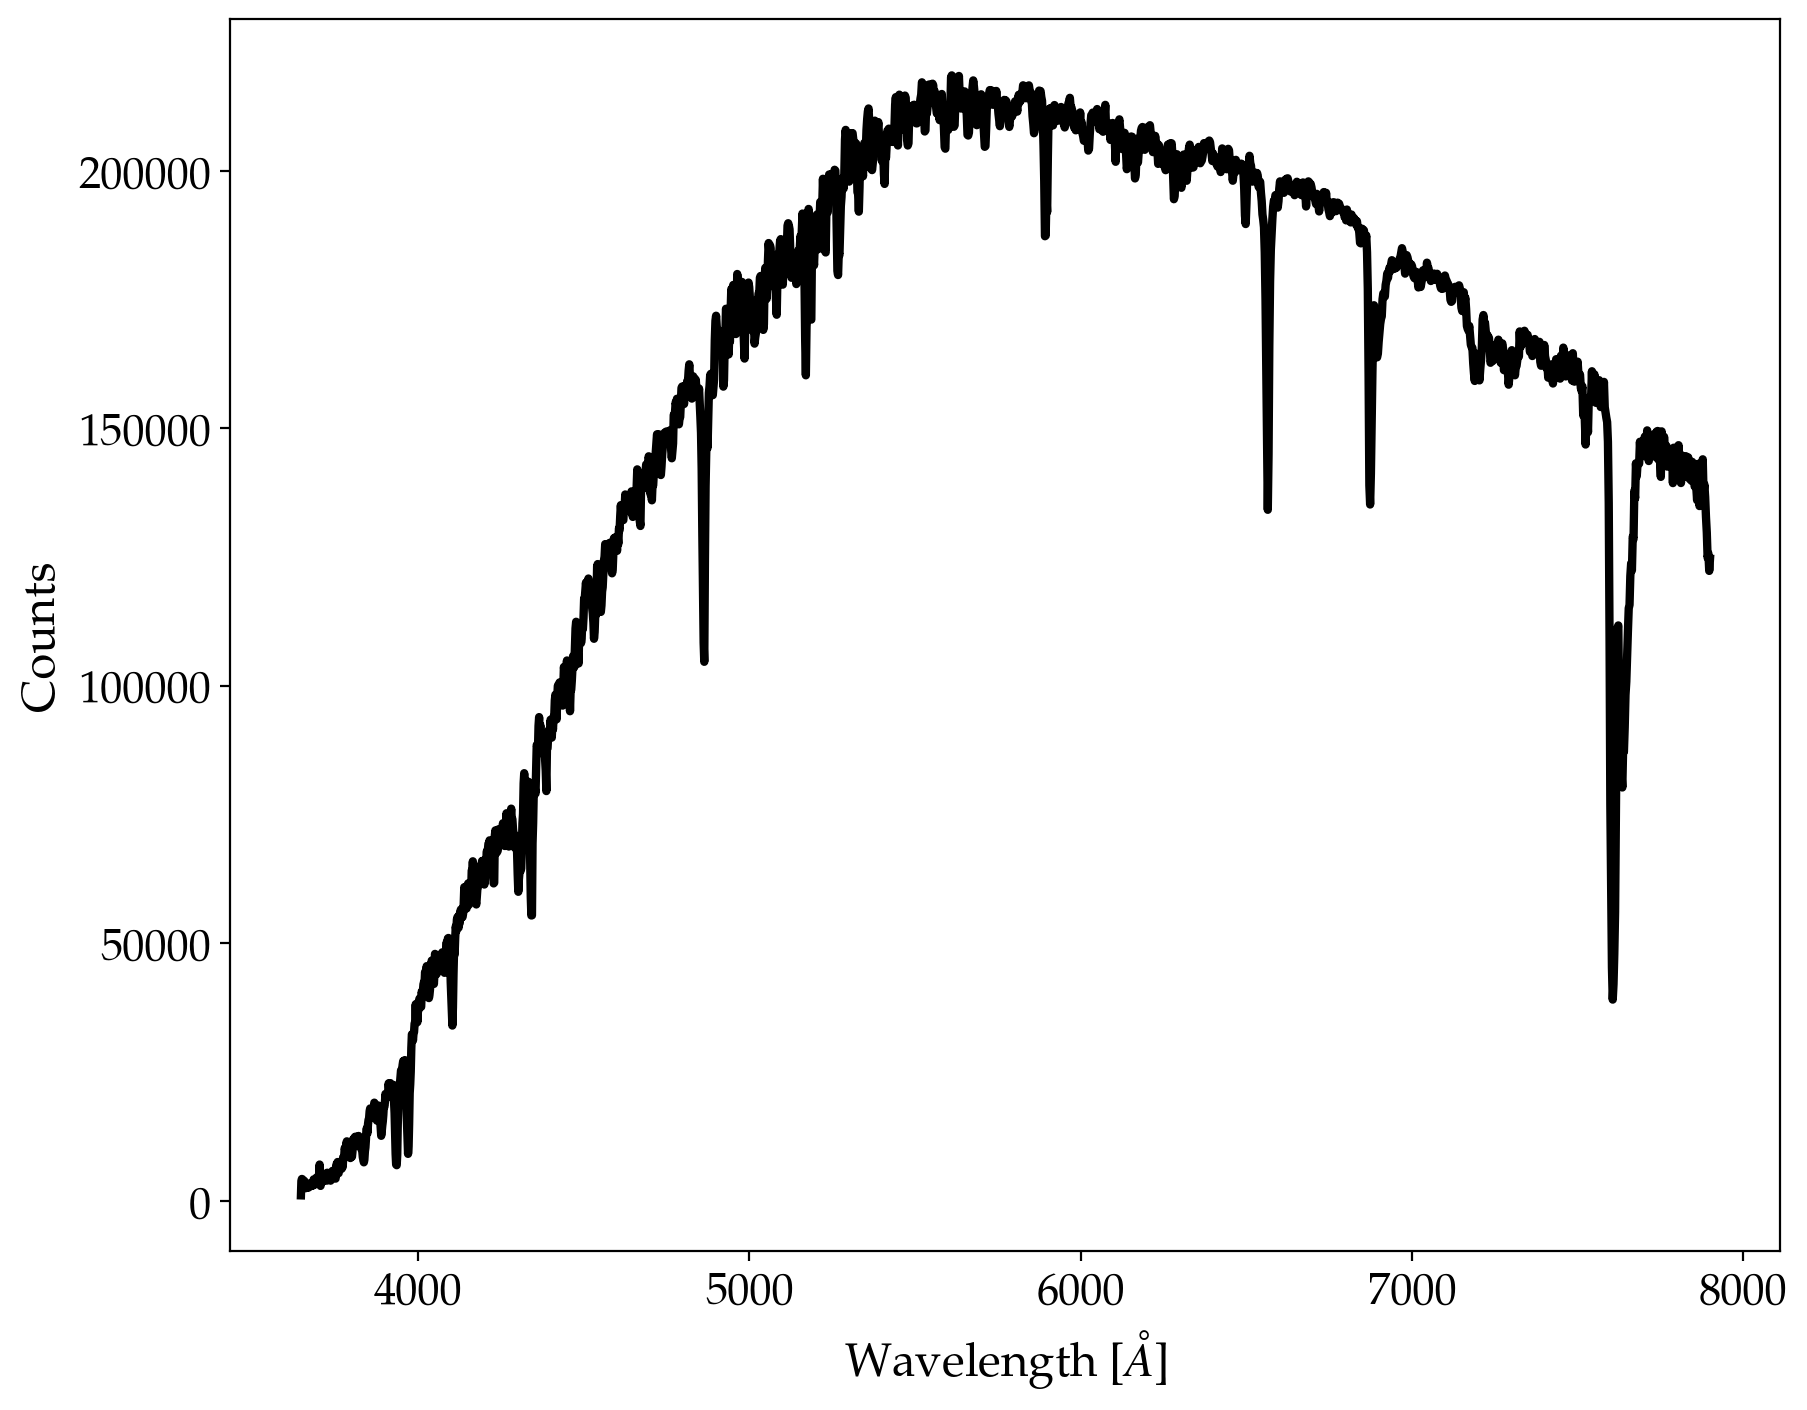

In [34]:
science_dir = reduc_dir / setup_dir / "Science"
for file in science_dir.rglob("spec2d*.fits"):
    print(f"pypeit_show_2dspec {file.absolute()}")
print()
for file in science_dir.rglob("spec1d*.fits"):
    target_index, snr = get_target_index(file)
    print(f"Index of target with larget S/N ({snr}): {target_index}")
    print(f"pypeit_show_1dspec {file.absolute()} --exten {target_index}")
    
for file in science_dir.rglob("spec1d*.fits"):
    plot_1dspec(file)

## Fluxing

### Create Sensitivity Function

In [35]:
print(f"cd {(reduc_dir / setup_dir).absolute()}\n")

for file in science_dir.rglob("spec1d*STD*.fits"):
    sens_file = file.parent / "sens_function_A.fits"
    print(f"pypeit_sensfunc {file.absolute()} -o {sens_file.absolute()}\n")

cd /home/tomas/Softwares/reductions/2020lao/REDUC_OB0016/gtc_osiris_A

pypeit_sensfunc /home/tomas/Softwares/reductions/2020lao/REDUC_OB0016/gtc_osiris_A/Science/spec1d_0002631304-20200803-OSIRIS-OsirisLongSlitSpectroscopy-SPSTD_BD+33_2642_OSIRIS_20200803T221230.840.fits -o /home/tomas/Softwares/reductions/2020lao/REDUC_OB0016/gtc_osiris_A/Science/sens_function_A.fits



### Check Sensitivity Function

In [11]:
for file in science_dir.glob("sens_function*.pdf"):
    print(str(file))
    display(IFrame(file, width=600, height=450))

REDUC_OB0016/gtc_osiris_A/Science/sens_function_A_fluxed_std.pdf


REDUC_OB0016/gtc_osiris_A/Science/sens_function_A_QA.pdf


REDUC_OB0016/gtc_osiris_A/Science/sens_function_A_throughput.pdf


### Smooth Sensitivity Function

Only if needed.

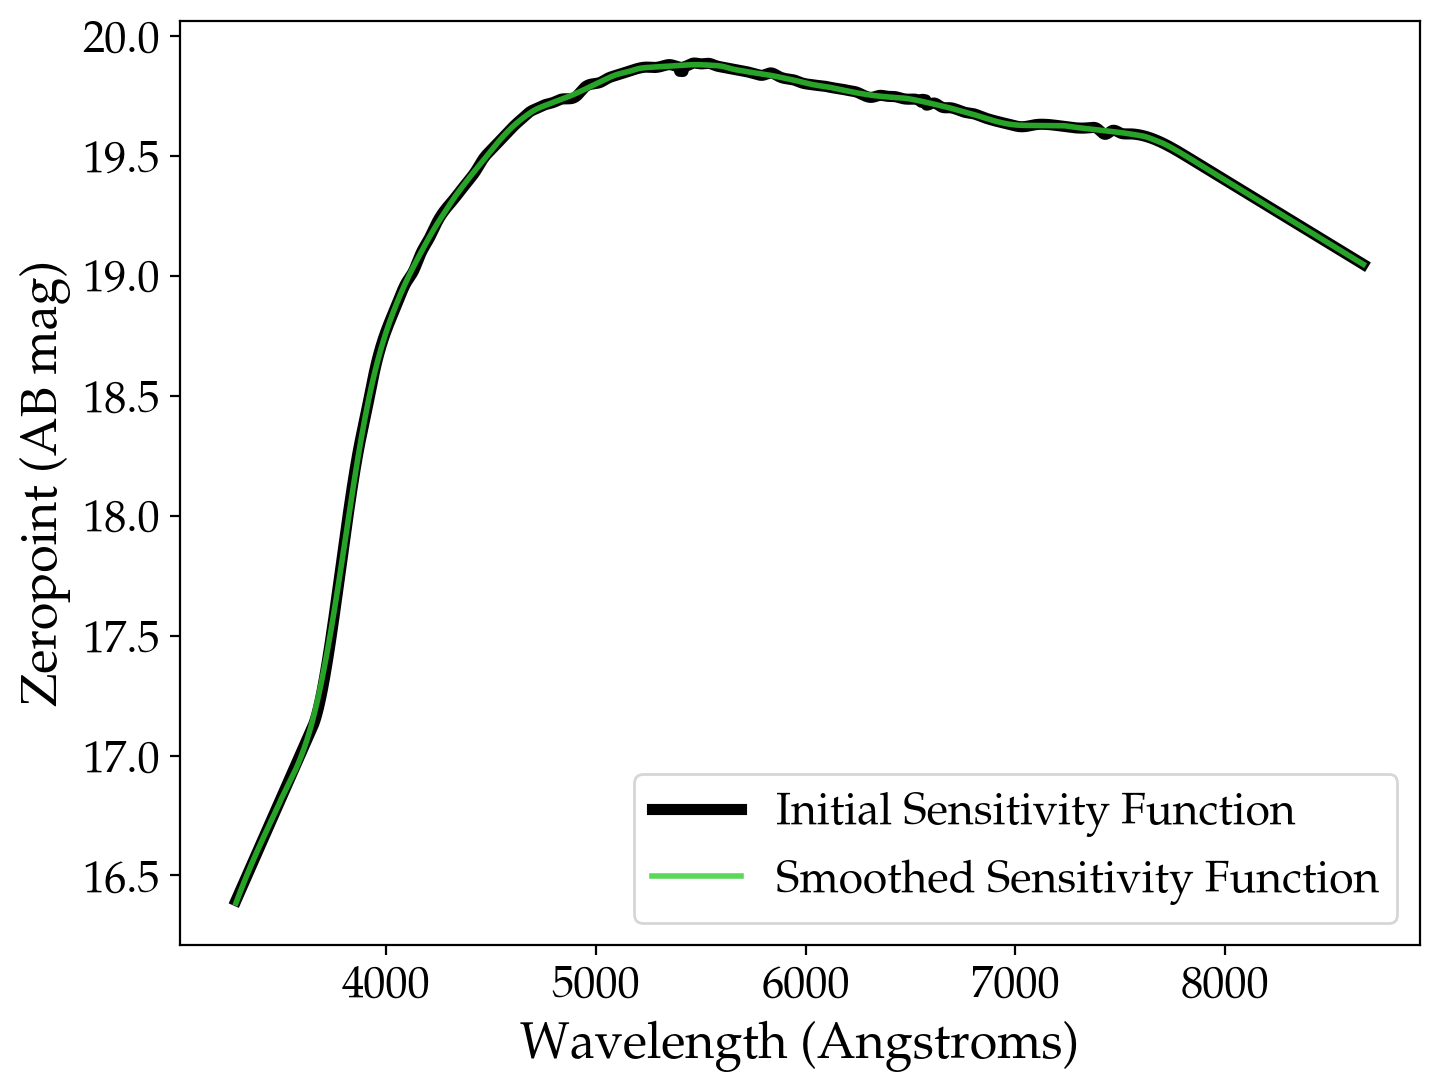

In [12]:
# load sensitivity function
hdu = fits.open(sens_file)
wave = hdu[2].data.T[0]
sens = hdu[3].data.T[0]
init_sens = sens.copy()

fig, ax = plt.subplots(figsize=(8, 6))

# use Savitzky–Golay filter
smooth_init_sens= savgol_filter(init_sens, window_length=300, polyorder=3) #
smooth_sens = savgol_filter(sens, window_length=300, polyorder=3)

ax.plot(wave, init_sens, lw=4, color='k', label='Initial Sensitivity Function')
#ax.plot(wave, smooth_init_sens, lw=2.5, color='red', label='Only Savitzky–Golay Filter', alpha=0.8)
ax.plot(wave, smooth_sens, lw=2, color='limegreen', label='Smoothed Sensitivity Function', alpha=0.8)

ax.set_xlabel("Wavelength (Angstroms)", fontsize=18)
ax.set_ylabel("Zeropoint (AB mag)", fontsize=18)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16)
plt.show()

# create new file
smooth_sens = smooth_sens.reshape(-1,1)
new_hdu = hdu.copy()
new_hdu[3].data = smooth_sens
smooth_sens_file = sens_file.parent / sens_file.name.replace(".fits", "_smoothed.fits")
new_hdu.writeto(smooth_sens_file, overwrite=True)

### Flux Calibration File

In [36]:
# gather science files and standard star
science_dir = reduc_dir / setup_dir / "Science"
sci_files = [file for file in science_dir.rglob("spec1d*.fits") if "STD" not in file.name]  # target files
std_file = [file for file in science_dir.rglob("spec1d*.fits") if "STD" in file.name][0]  # standard star (assuming a single file)

# create the calibration file for pypeit
flux_calib_file = reduc_dir / setup_dir / "flux_calibration.txt"
with open(flux_calib_file, "w") as file:
    text = ("flux read\n\t"
            "filename | sensfile\n"
           )
    for sci_file in science_dir.rglob("spec1d*.fits"):
        text += f"\t{sci_file.absolute()} | {smooth_sens_file.absolute()}\n"
        #text += f"\t{sci_file.absolute()} | {str(smooth_sens_file.absolute()).replace("_smoothed", "")}\n"
    text += "flux end"
    file.write(text)
    print(text)

flux read
	filename | sensfile
	/home/tomas/Softwares/reductions/2020lao/REDUC_OB0016/gtc_osiris_A/Science/spec1d_0002631304-20200803-OSIRIS-OsirisLongSlitSpectroscopy-SPSTD_BD+33_2642_OSIRIS_20200803T221230.840.fits | /home/tomas/Softwares/reductions/2020lao/REDUC_OB0016/gtc_osiris_A/Science/sens_function_A_smoothed.fits
	/home/tomas/Softwares/reductions/2020lao/REDUC_OB0016/gtc_osiris_A/Science/spec1d_0002631344-20200803-OSIRIS-OsirisLongSlitSpectroscopy-SN2020lao_OSIRIS_20200803T235455.840.fits | /home/tomas/Softwares/reductions/2020lao/REDUC_OB0016/gtc_osiris_A/Science/sens_function_A_smoothed.fits
	/home/tomas/Softwares/reductions/2020lao/REDUC_OB0016/gtc_osiris_A/Science/spec1d_0002631345-20200803-OSIRIS-OsirisLongSlitSpectroscopy-SN2020lao_OSIRIS_20200804T002019.840.fits | /home/tomas/Softwares/reductions/2020lao/REDUC_OB0016/gtc_osiris_A/Science/sens_function_A_smoothed.fits
flux end


### Run Flux Calibration

In [37]:
print(f"pypeit_flux_calib {flux_calib_file.absolute()}")

pypeit_flux_calib /home/tomas/Softwares/reductions/2020lao/REDUC_OB0016/gtc_osiris_A/flux_calibration.txt


## Telluric Correction

tellurics = {"O2-A": [6855, 6940],
             "H2O-A": [7155, 7332],
             "O2-B": [7580, 7700],
             "H2O-B": [8110, 8357],
}

No overlap with telluric H2O-B: [8110, 8357]


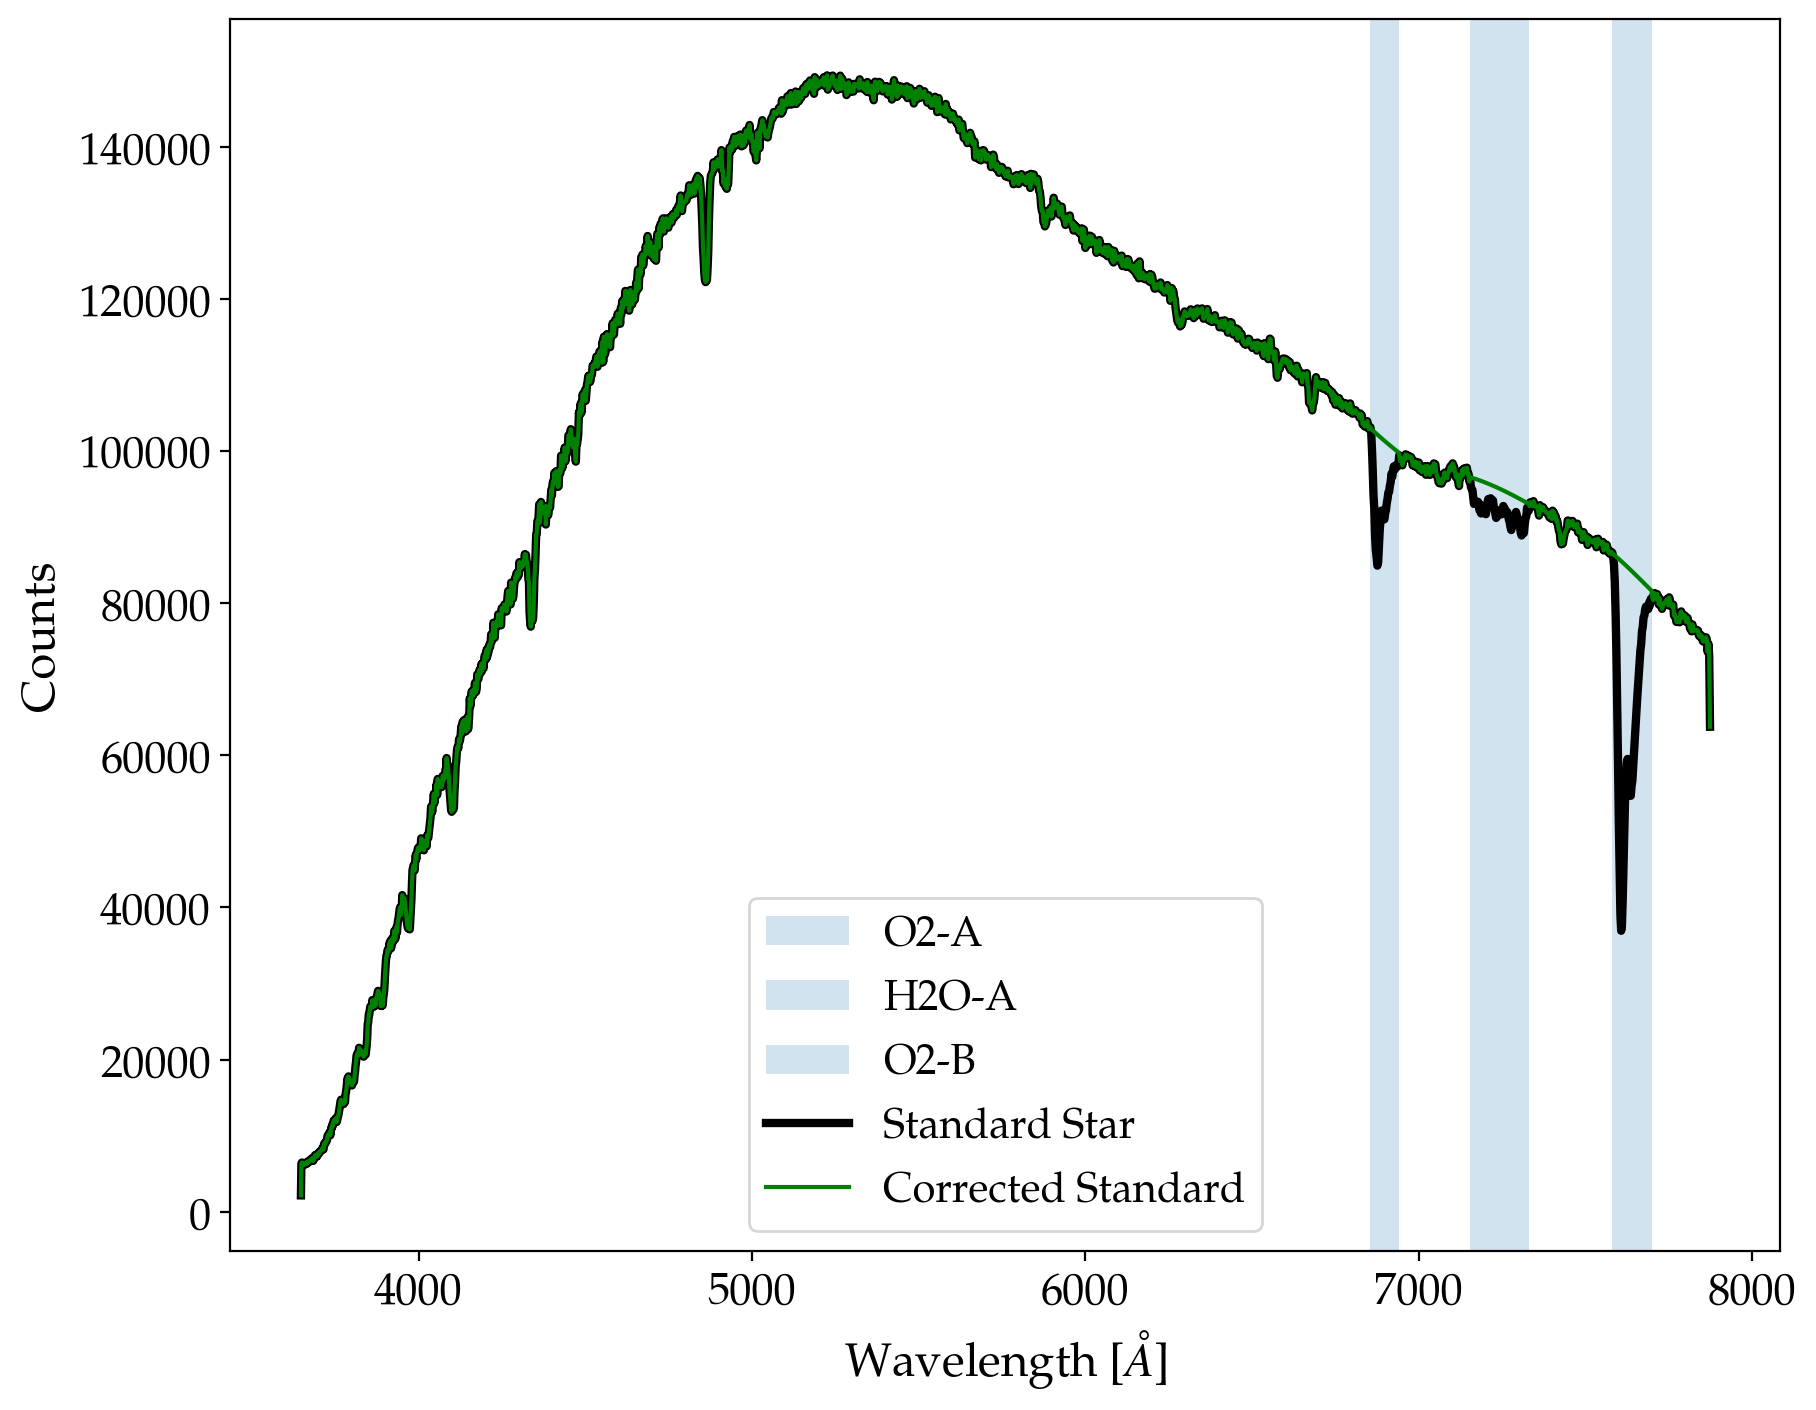

In [15]:
hdu = fits.open(std_file)

i = 2
wave = hdu[i].data['OPT_WAVE']
flux = hdu[i].data['OPT_COUNTS']
std_spectrum = Spectrum1D(spectral_axis=wave * u.AA, flux=flux * u.ct)

tellurics = {"O2-A": [6855, 6940],
             "H2O-A": [7155, 7332],
             "O2-B": [7580, 7700],
             "H2O-B": [8110, 8357],
}

fig, ax = plt.subplots(figsize=(10, 8))

# create an array that will have NaN at the tellurics position
flux_masked = flux.copy()

for telluric, region in tellurics.items():
    tell_min, tell_max = region
    window = [((tell_min - 150) * u.AA, tell_min * u.AA),
              (tell_max * u.AA, (tell_max + 150) * u.AA)]
    try:
        cont_fit = fit_continuum(std_spectrum, window=window)
        mask = (tell_min < wave) & (wave < tell_max)
        flux_masked[mask] = cont_fit(wave[mask] * u.AA)
        ax.axvspan(tell_min, tell_max, alpha=0.2, label=telluric)
    except:
        print(f"No overlap with telluric {telluric}: {region}")

#Plot the standard star's spectrum
plt.plot(wave, flux, lw=3, color='k', label='Standard Star')

#Plot the "fit"
plt.plot(wave, flux_masked, color='green', label='Corrected Standard')

#ax.set_title('GD153',fontsize=20)
ax.set_xlabel(r'Wavelength [$\AA$]',fontsize=17)
ax.set_ylabel('Counts',fontsize=17)
ax.tick_params(labelsize=16)
ax.legend(fontsize=15)

### TODO: ADD TELLURIC CORRECTION

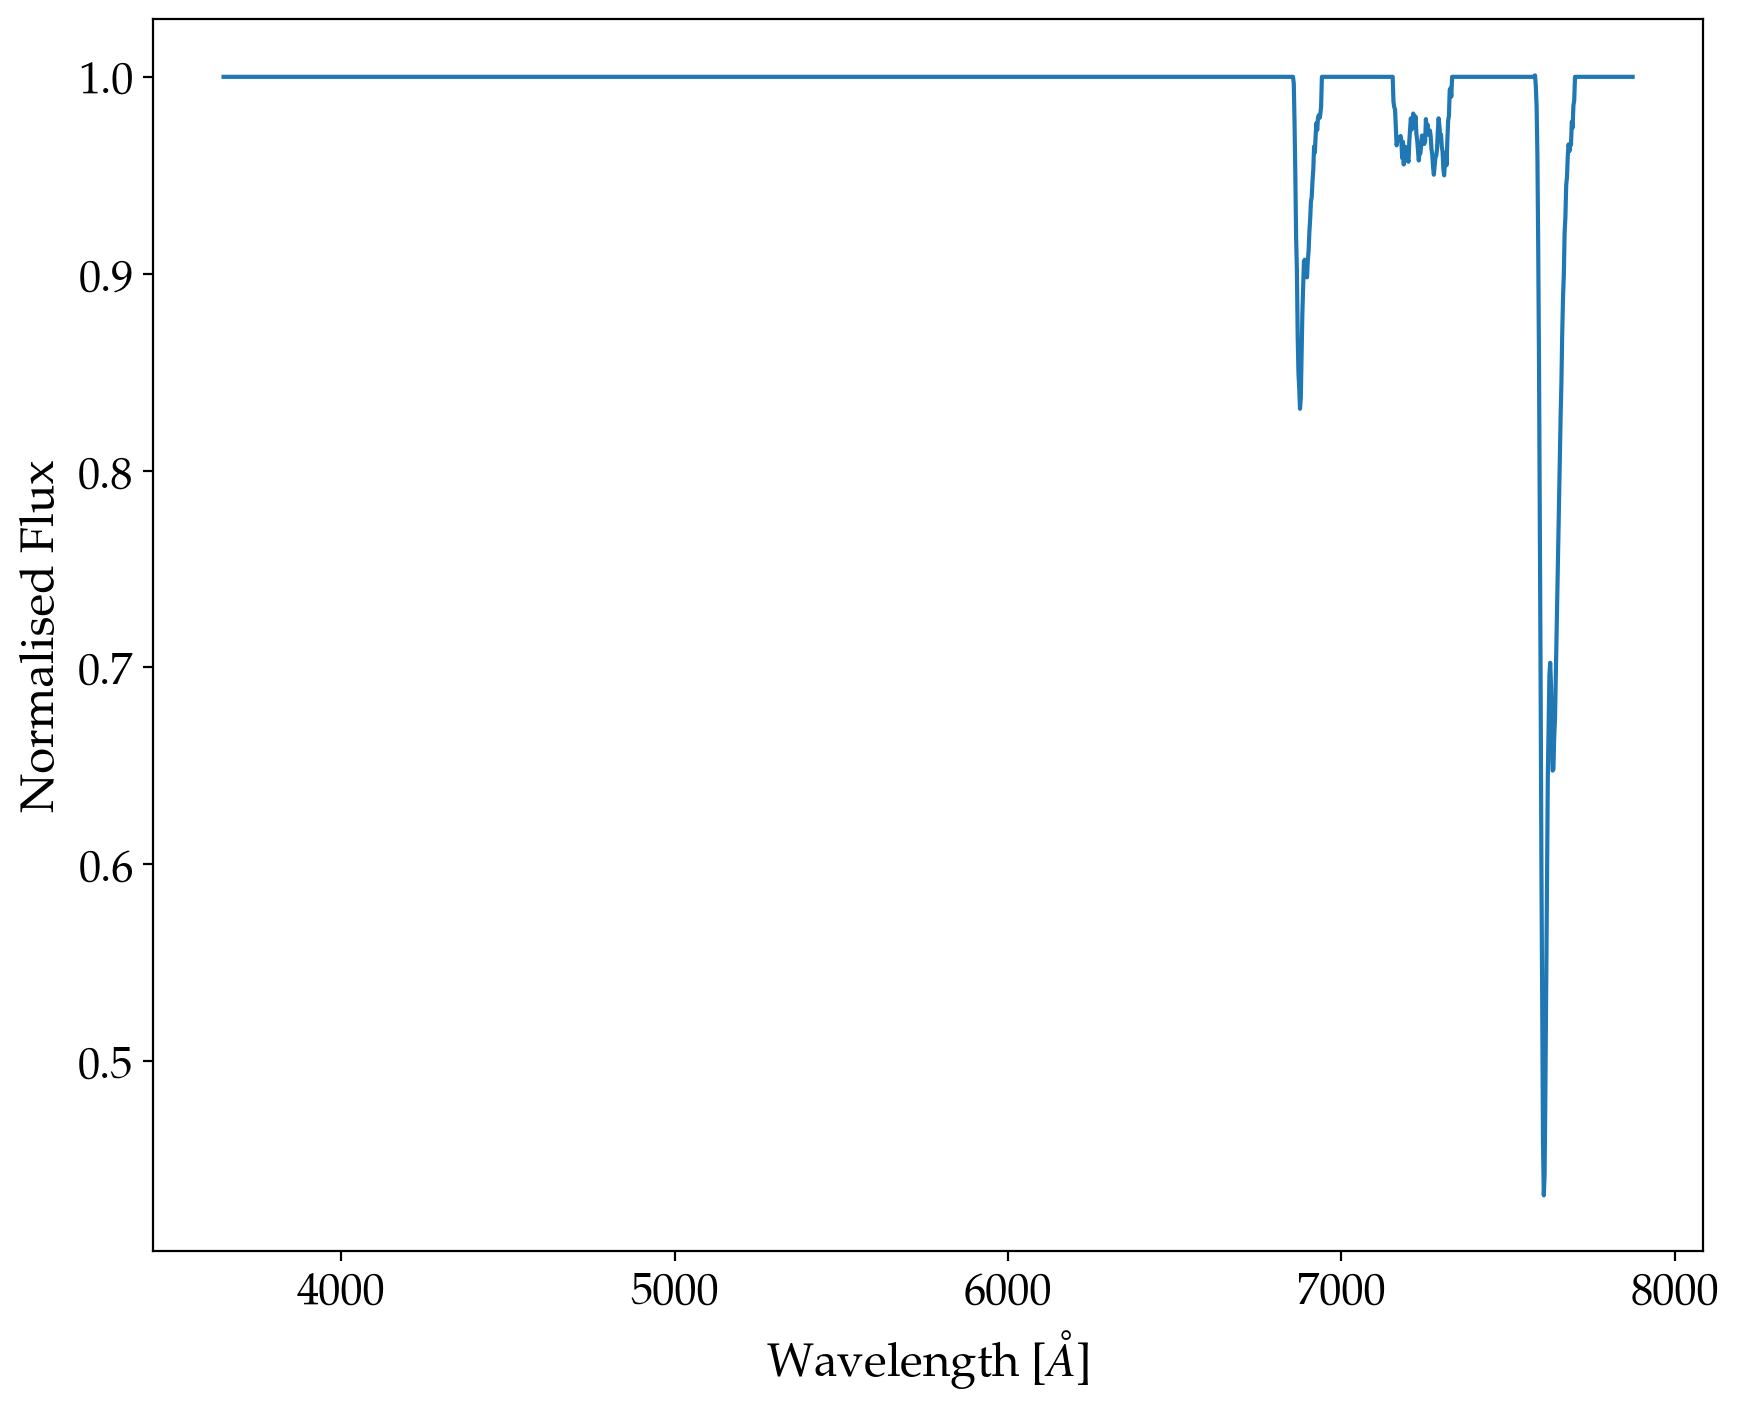

In [16]:
tell_corr = flux / flux_masked

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(wave, tell_corr)

ax.set_xlabel(r'Wavelength [$\AA$]',fontsize=17)
ax.set_ylabel('Normalised Flux',fontsize=17)
ax.tick_params(labelsize=16)

#Save it as a FITS file
spectrum = Spectrum1D(spectral_axis=wave * u.AA, flux=tell_corr * u.ct)

## Final Plots and Outputs

In [38]:
def get_spectra(file: str, ext: int = 1, flux_keyword: str = "OPT_COUNTS") -> tuple[np.ndarray, np.ndarray, tuple]:
    """Extracts the spectra and some header information.
    """
    hdu_list = fits.open(file)
    hdu = hdu_list[ext]
    wave = hdu.data['OPT_WAVE']
    flux = hdu.data[flux_keyword]

    name = hdu_list[0].header["TARGET"]
    inst = hdu_list[0].header["INSTRUME"]
    grism = hdu_list[0].header["GRISM"]
    date = hdu_list[0].header["DATETIME"]
    img_info = (name, inst, grism, date)

    return wave, flux, img_info

/tmp/ipykernel_32353/2360345798.py:10: RuntimeWarning: invalid value encountered in log10
  ax.plot(wave, np.log10(flux), lw=3, color='k', label=label)


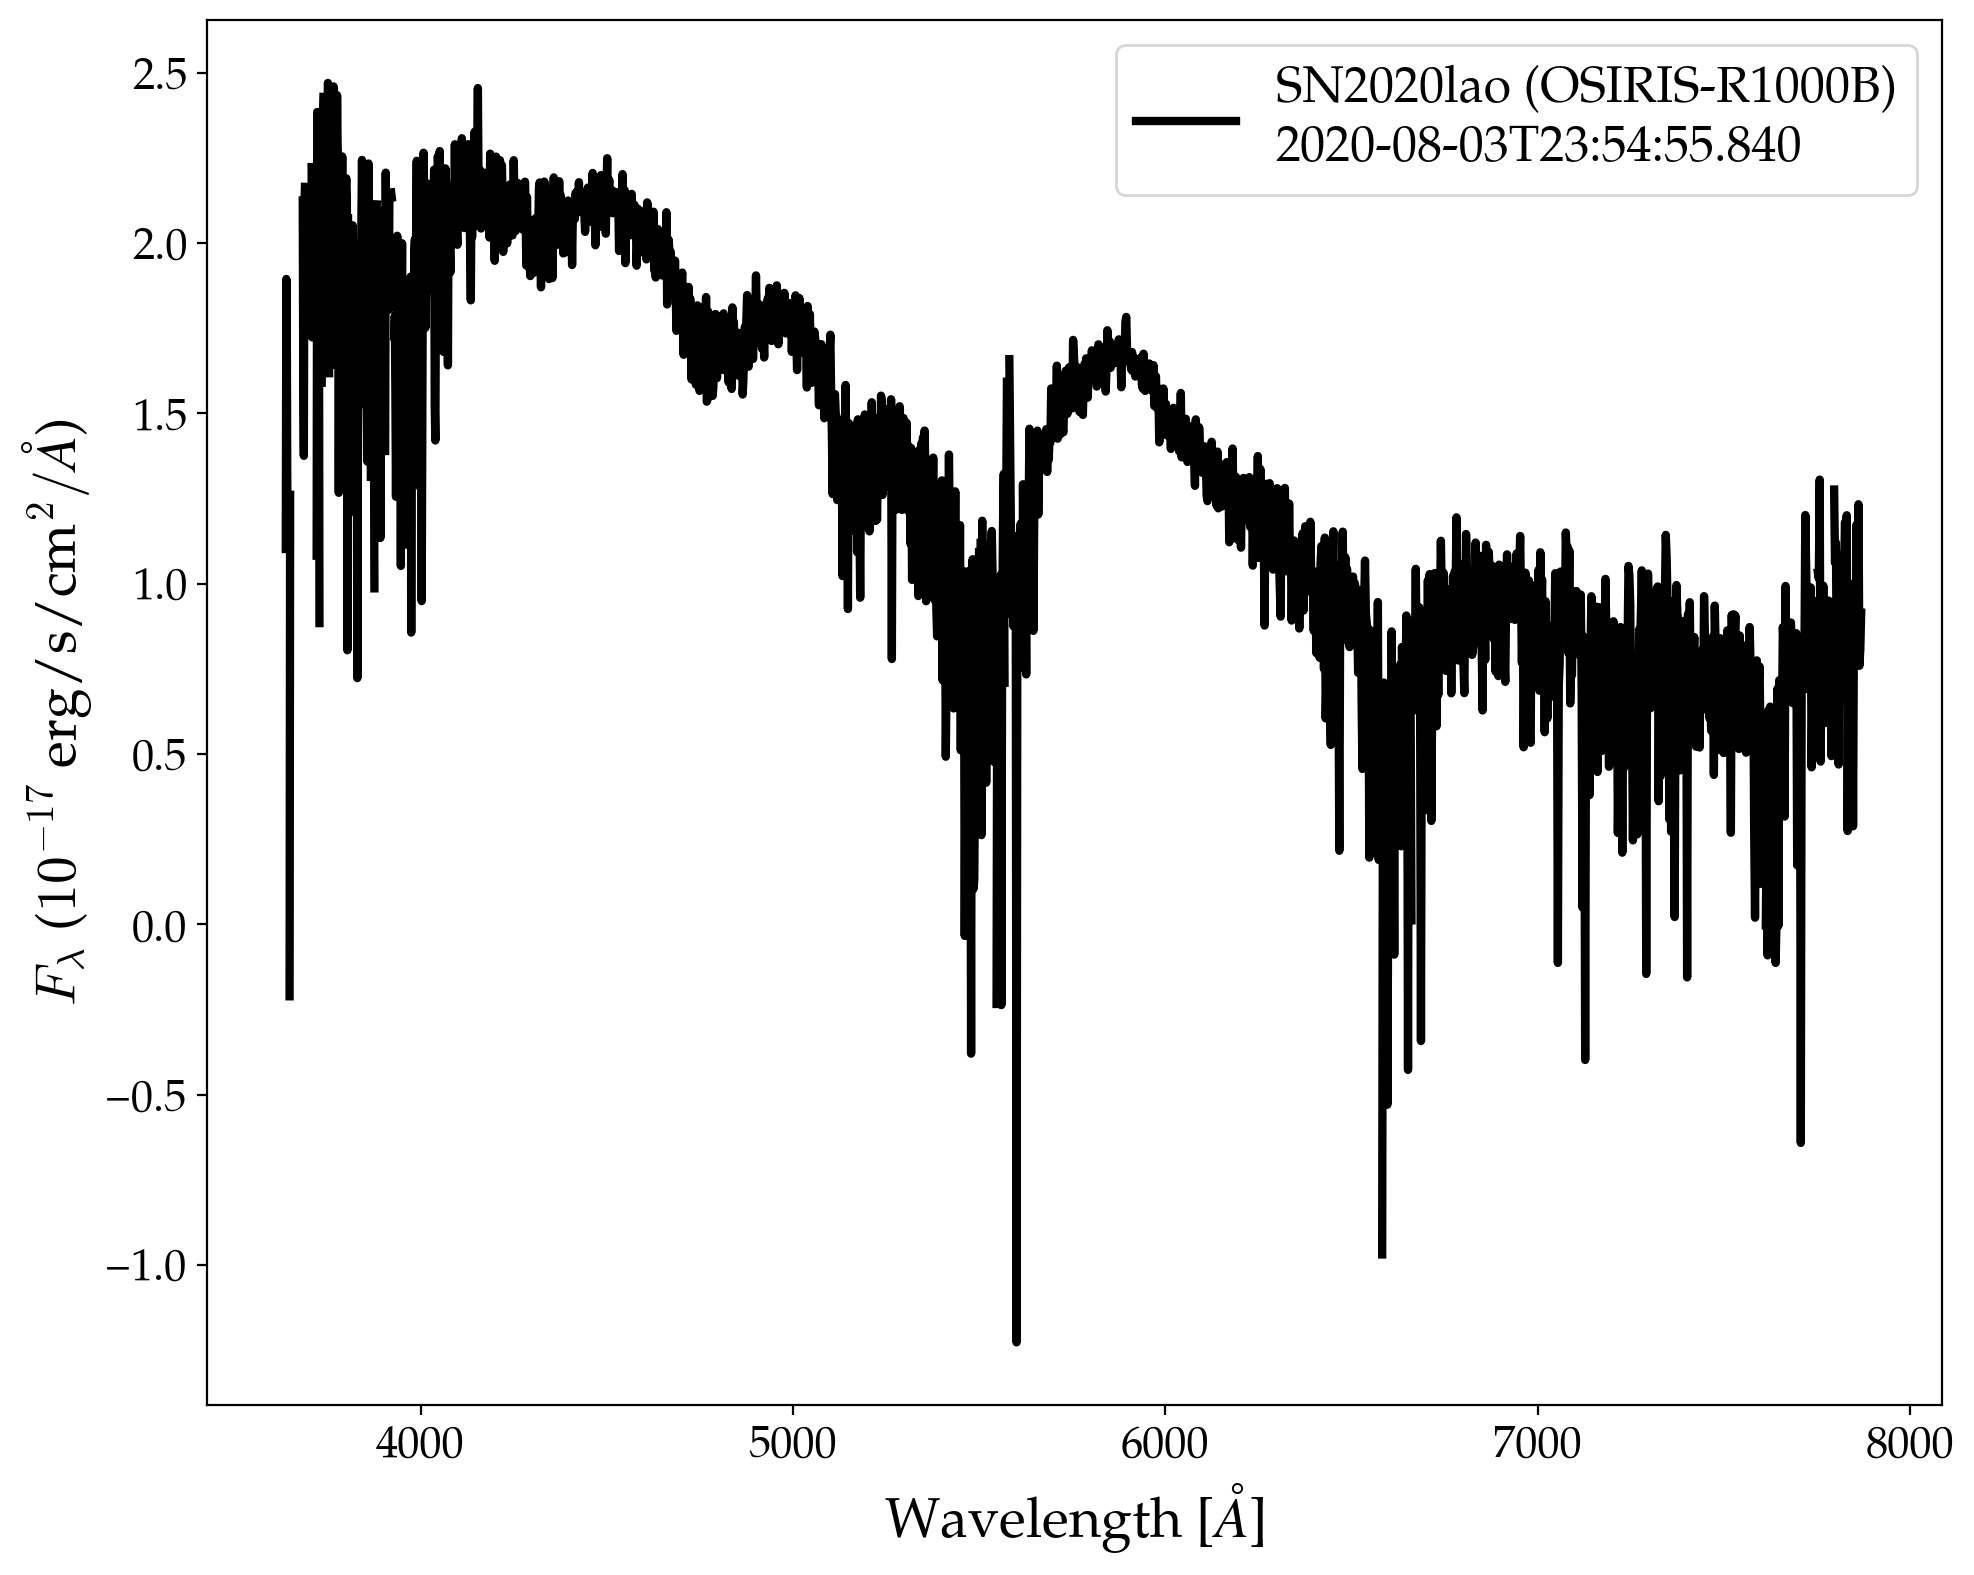

/tmp/ipykernel_32353/2360345798.py:10: RuntimeWarning: invalid value encountered in log10
  ax.plot(wave, np.log10(flux), lw=3, color='k', label=label)


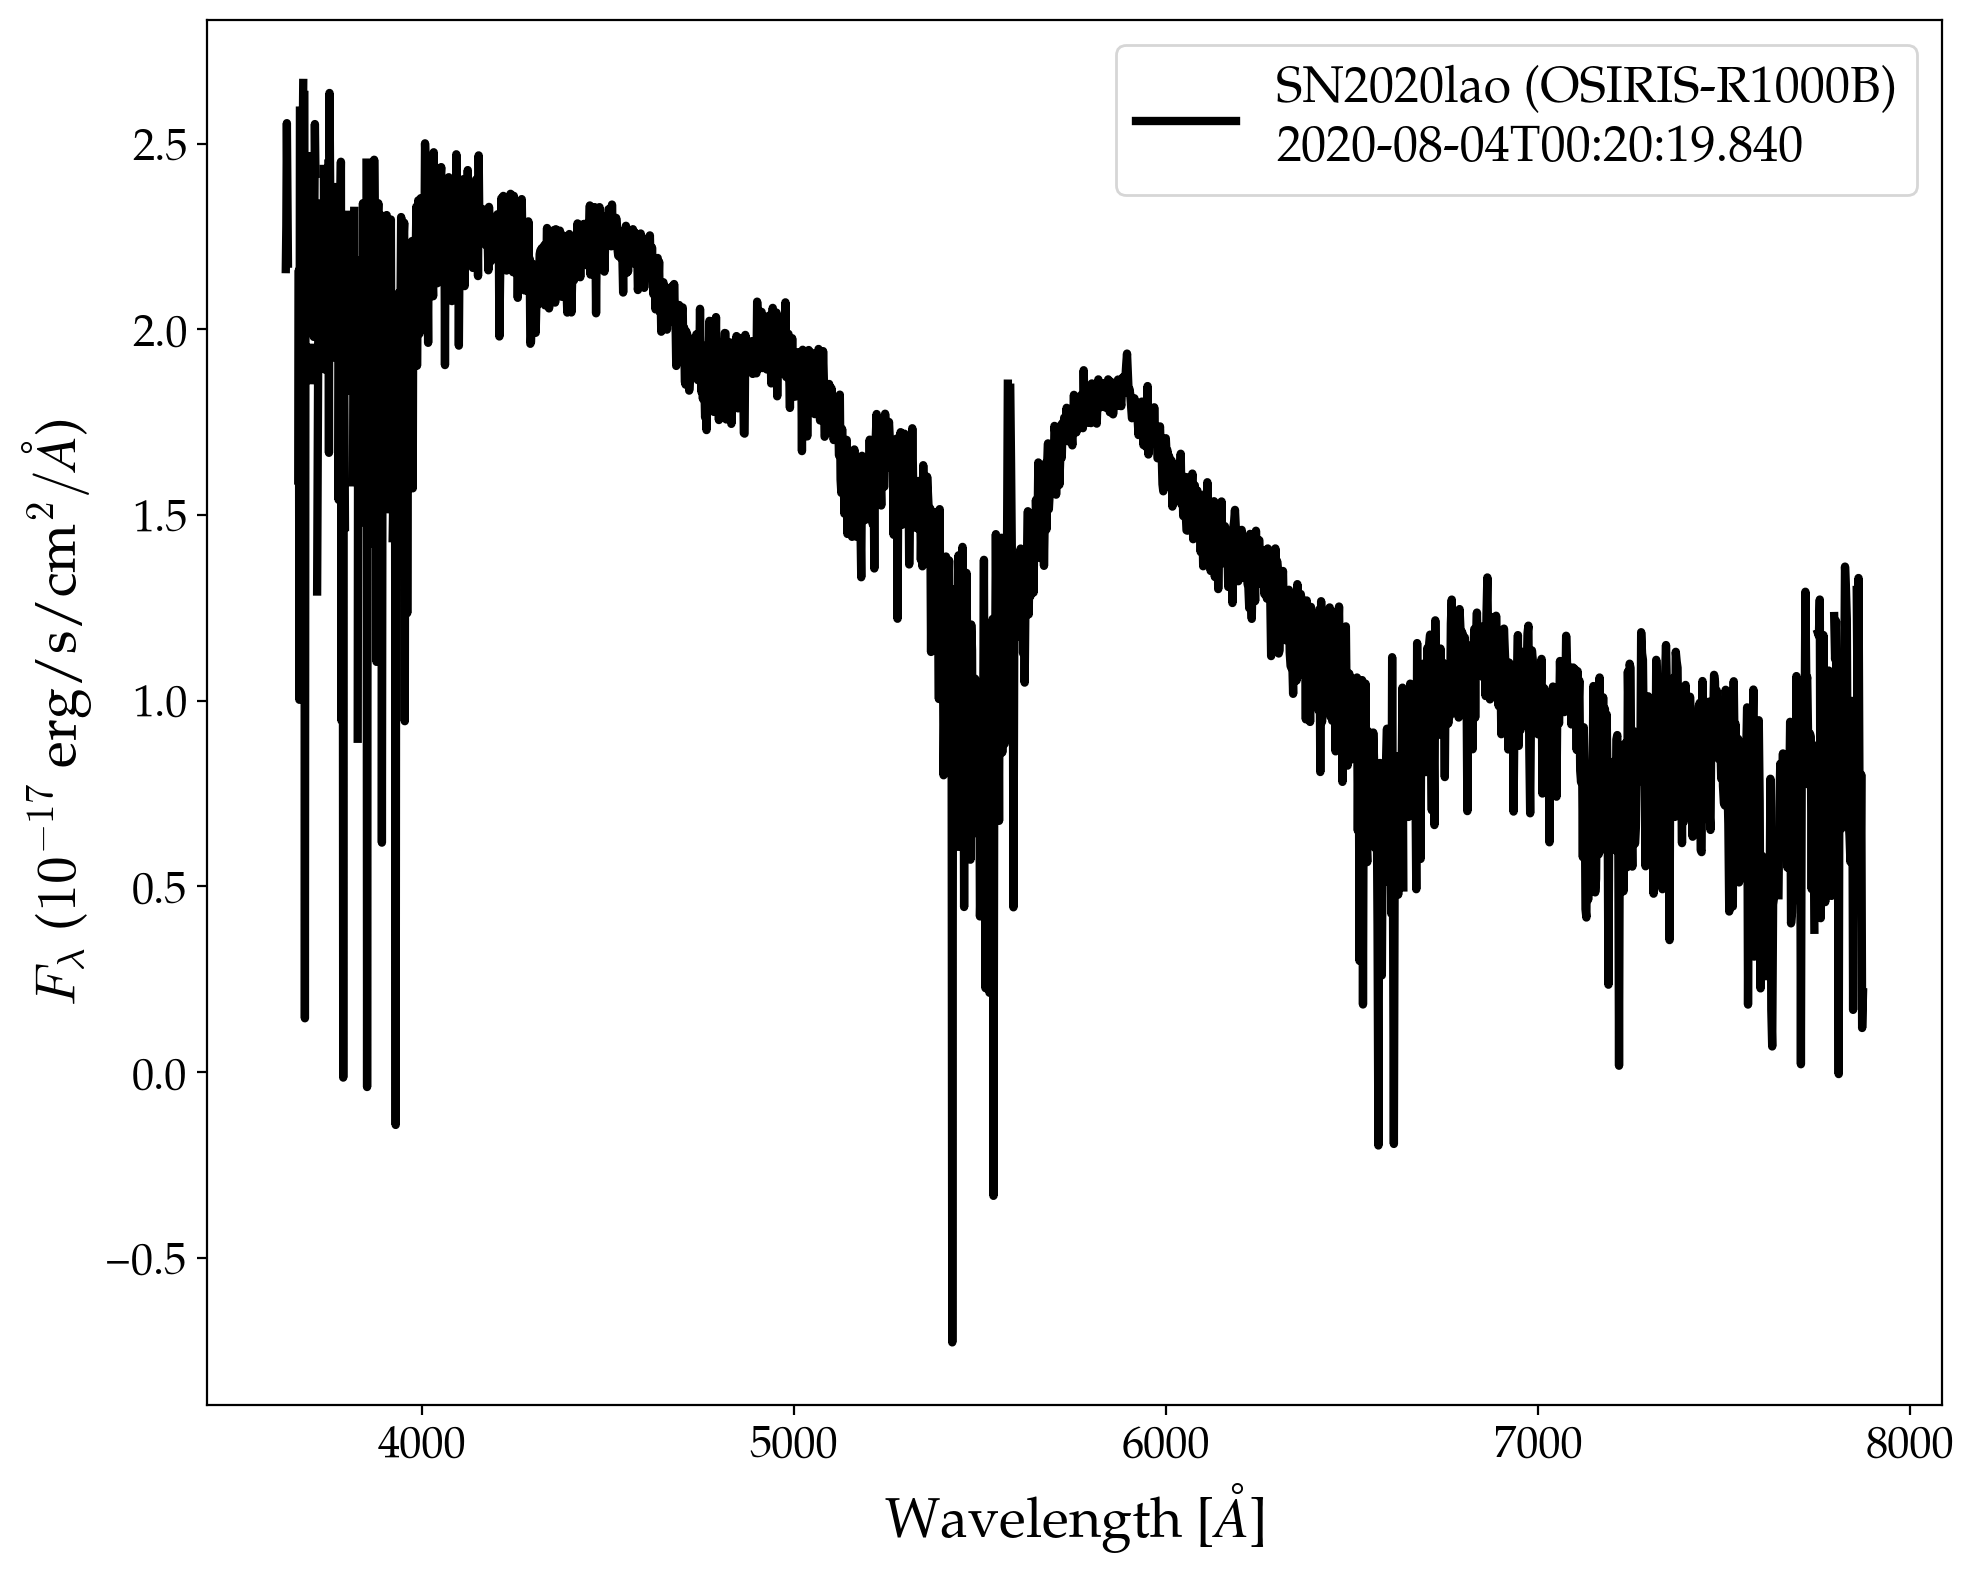

In [40]:
for sci_file in sci_files:
    target_index, snr = get_target_index(sci_file)
    target_index = 3

    wave, flux, img_info = get_spectra(sci_file, target_index, flux_keyword="OPT_FLAM")
    name, inst, grism, date = img_info
    label = f"{name} ({inst}-{grism})\n{date}"
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(wave, np.log10(flux), lw=3, color='k', label=label)
    
    ax.set_xlabel(r'Wavelength [$\AA$]',fontsize=20)
    ax.set_ylabel(r'$F_{\lambda}$ ($10^{-17}$ erg/s/cm$^2/\AA$)',fontsize=20)
    ax.tick_params(labelsize=16)
    ax.legend(fontsize=18)
    #ax.set_ylim(-25.0, None)
    plt.tight_layout()
    outfile = Path(f"{name}_{inst}_{grism}_{date}.jpg")
    plt.savefig(outfile)
    plt.show()

    # to text file
    np.savetxt(outfile.with_suffix(".txt"), np.array([wave, flux*10e-17]).T)

### Combine Spectra

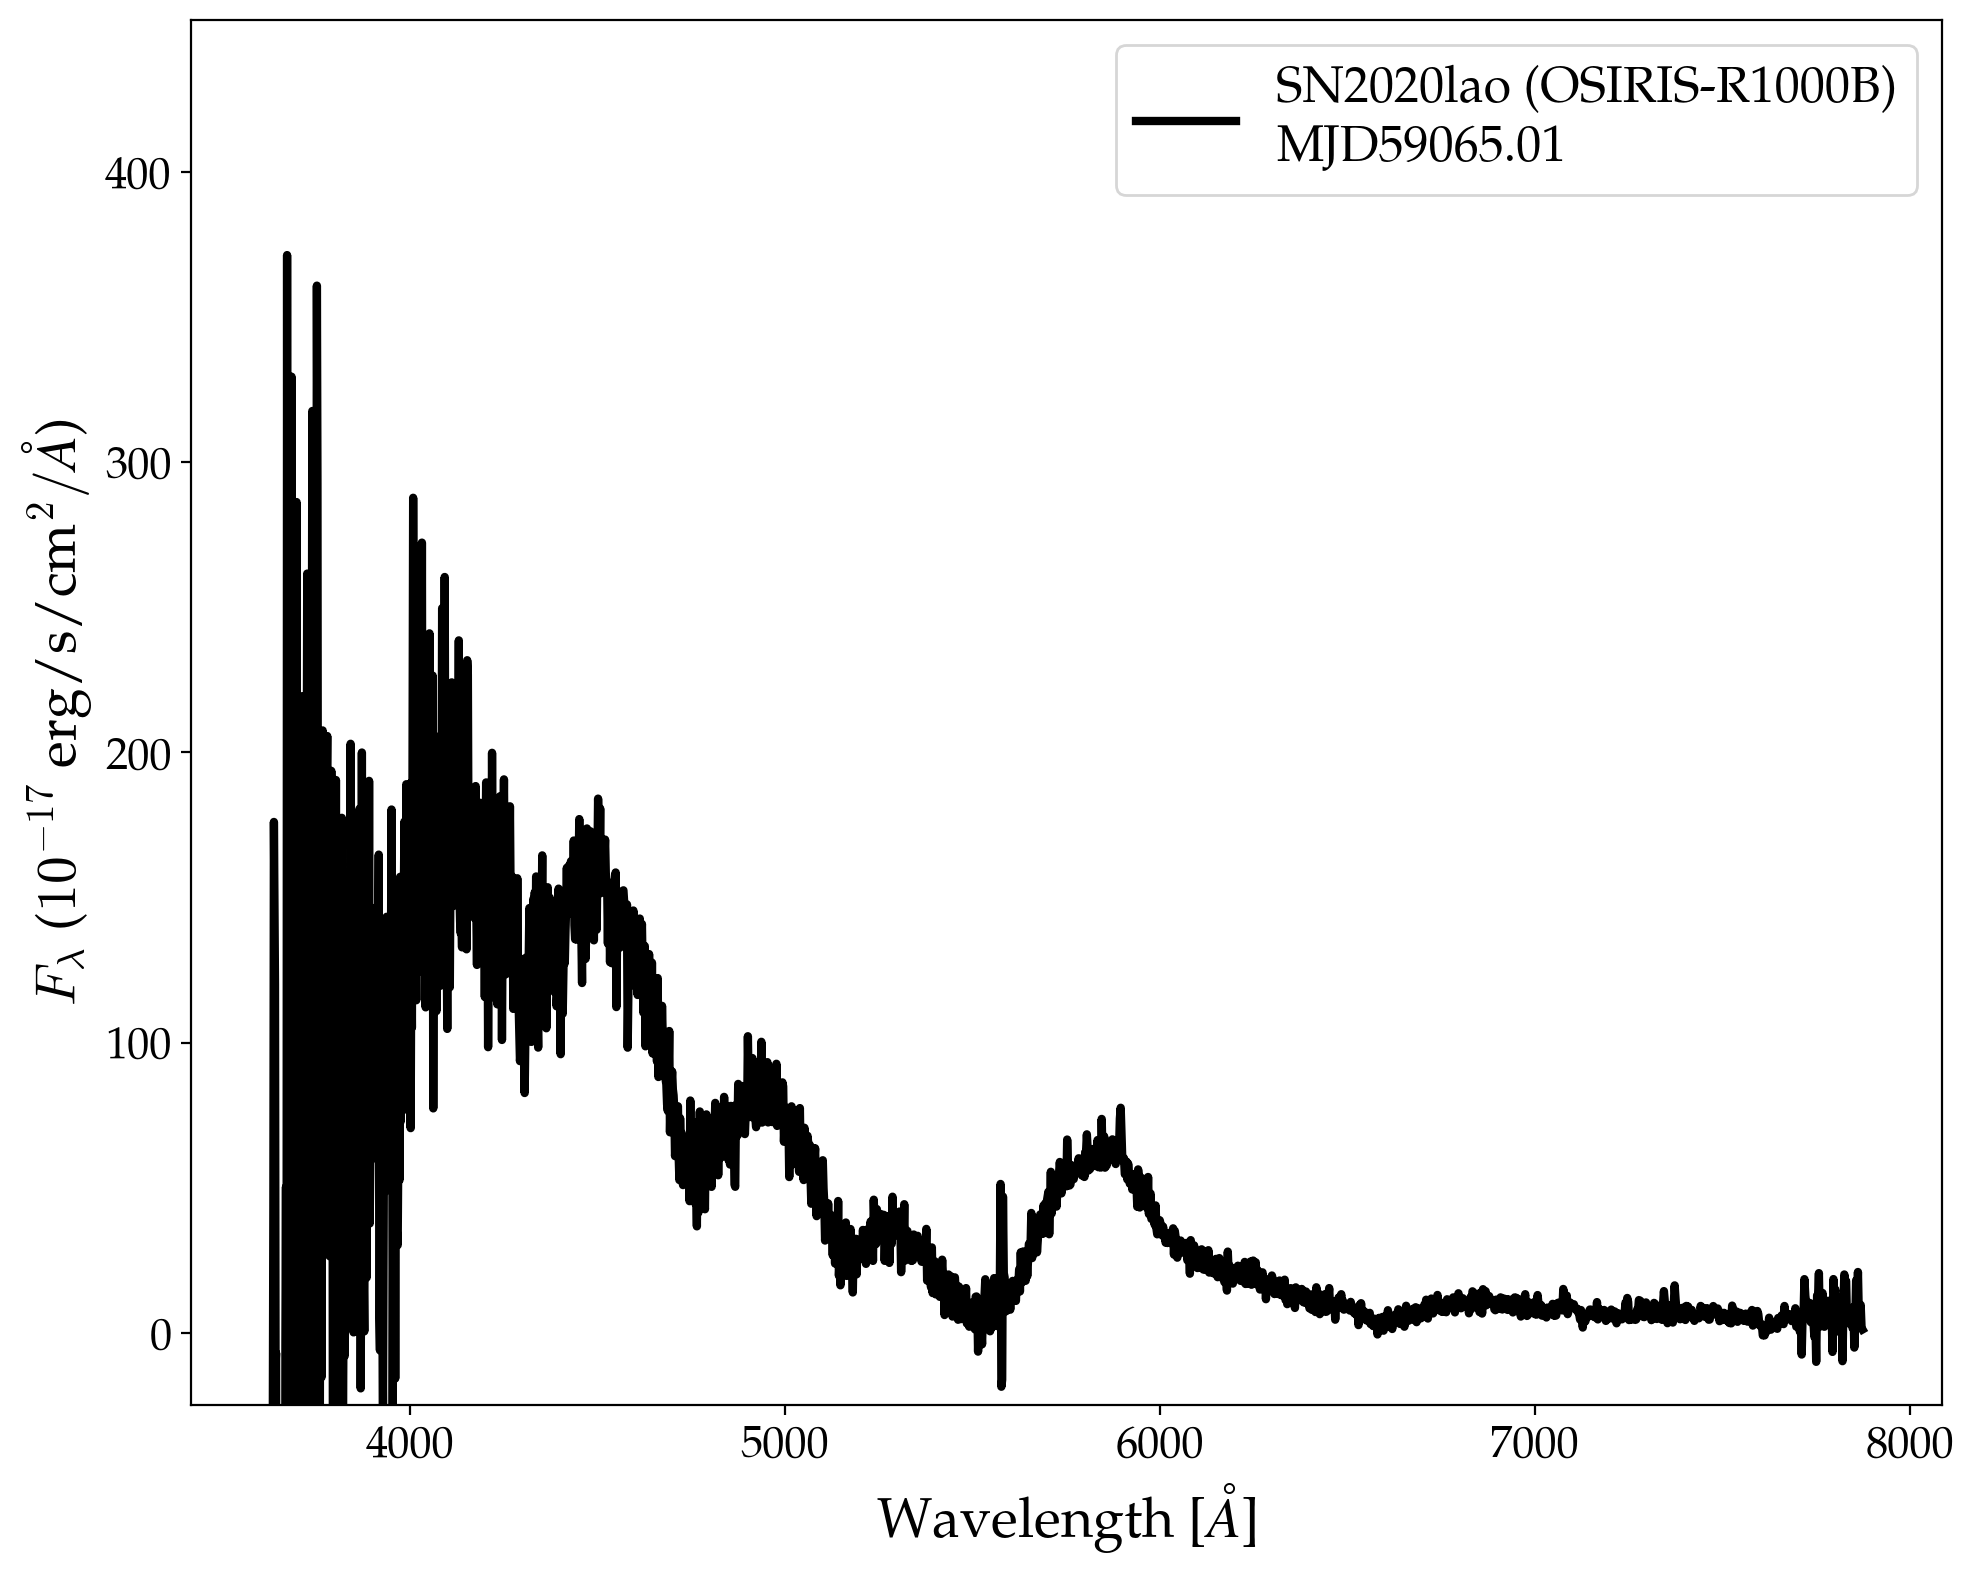

In [48]:
from astropy.time import Time
sci_file1 = sci_files[0]
sci_file2 = sci_files[1]
target_index = 2

wave1, flux1, img_info1 = get_spectra(sci_file1, target_index, flux_keyword="OPT_FLAM")
wave2, flux2, img_info2 = get_spectra(sci_file2, target_index, flux_keyword="OPT_FLAM")
name, inst, grism, date1 = img_info1
# get mid date
date2 = img_info2[-1]
isot1 = Time(date1, format="isot")
isot2 = Time(date2, format="isot")
mjd = (isot1.mjd + isot2.mjd) / 2
label = f"{name} ({inst}-{grism})\nMJD{mjd:.2f}"

wave = wave1.copy()
flux2 = np.interp(wave, wave2, flux2)
flux = np.mean([flux1, flux2], axis=0)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(wave, flux, lw=3, color='k', label=label)

ax.set_xlabel(r'Wavelength [$\AA$]',fontsize=20)
ax.set_ylabel(r'$F_{\lambda}$ ($10^{-17}$ erg/s/cm$^2/\AA$)',fontsize=20)
ax.tick_params(labelsize=16)
ax.legend(fontsize=18)
ax.set_ylim(-25.0, None)
plt.tight_layout()
outfile = Path(f"{name}_{inst}_{grism}_{mjd:.2f}_combined.jpg")
plt.savefig(outfile)
plt.show()

# to text file
np.savetxt(outfile.with_suffix(".txt"), np.array([wave, flux*10e-17]).T)

### Standard Star

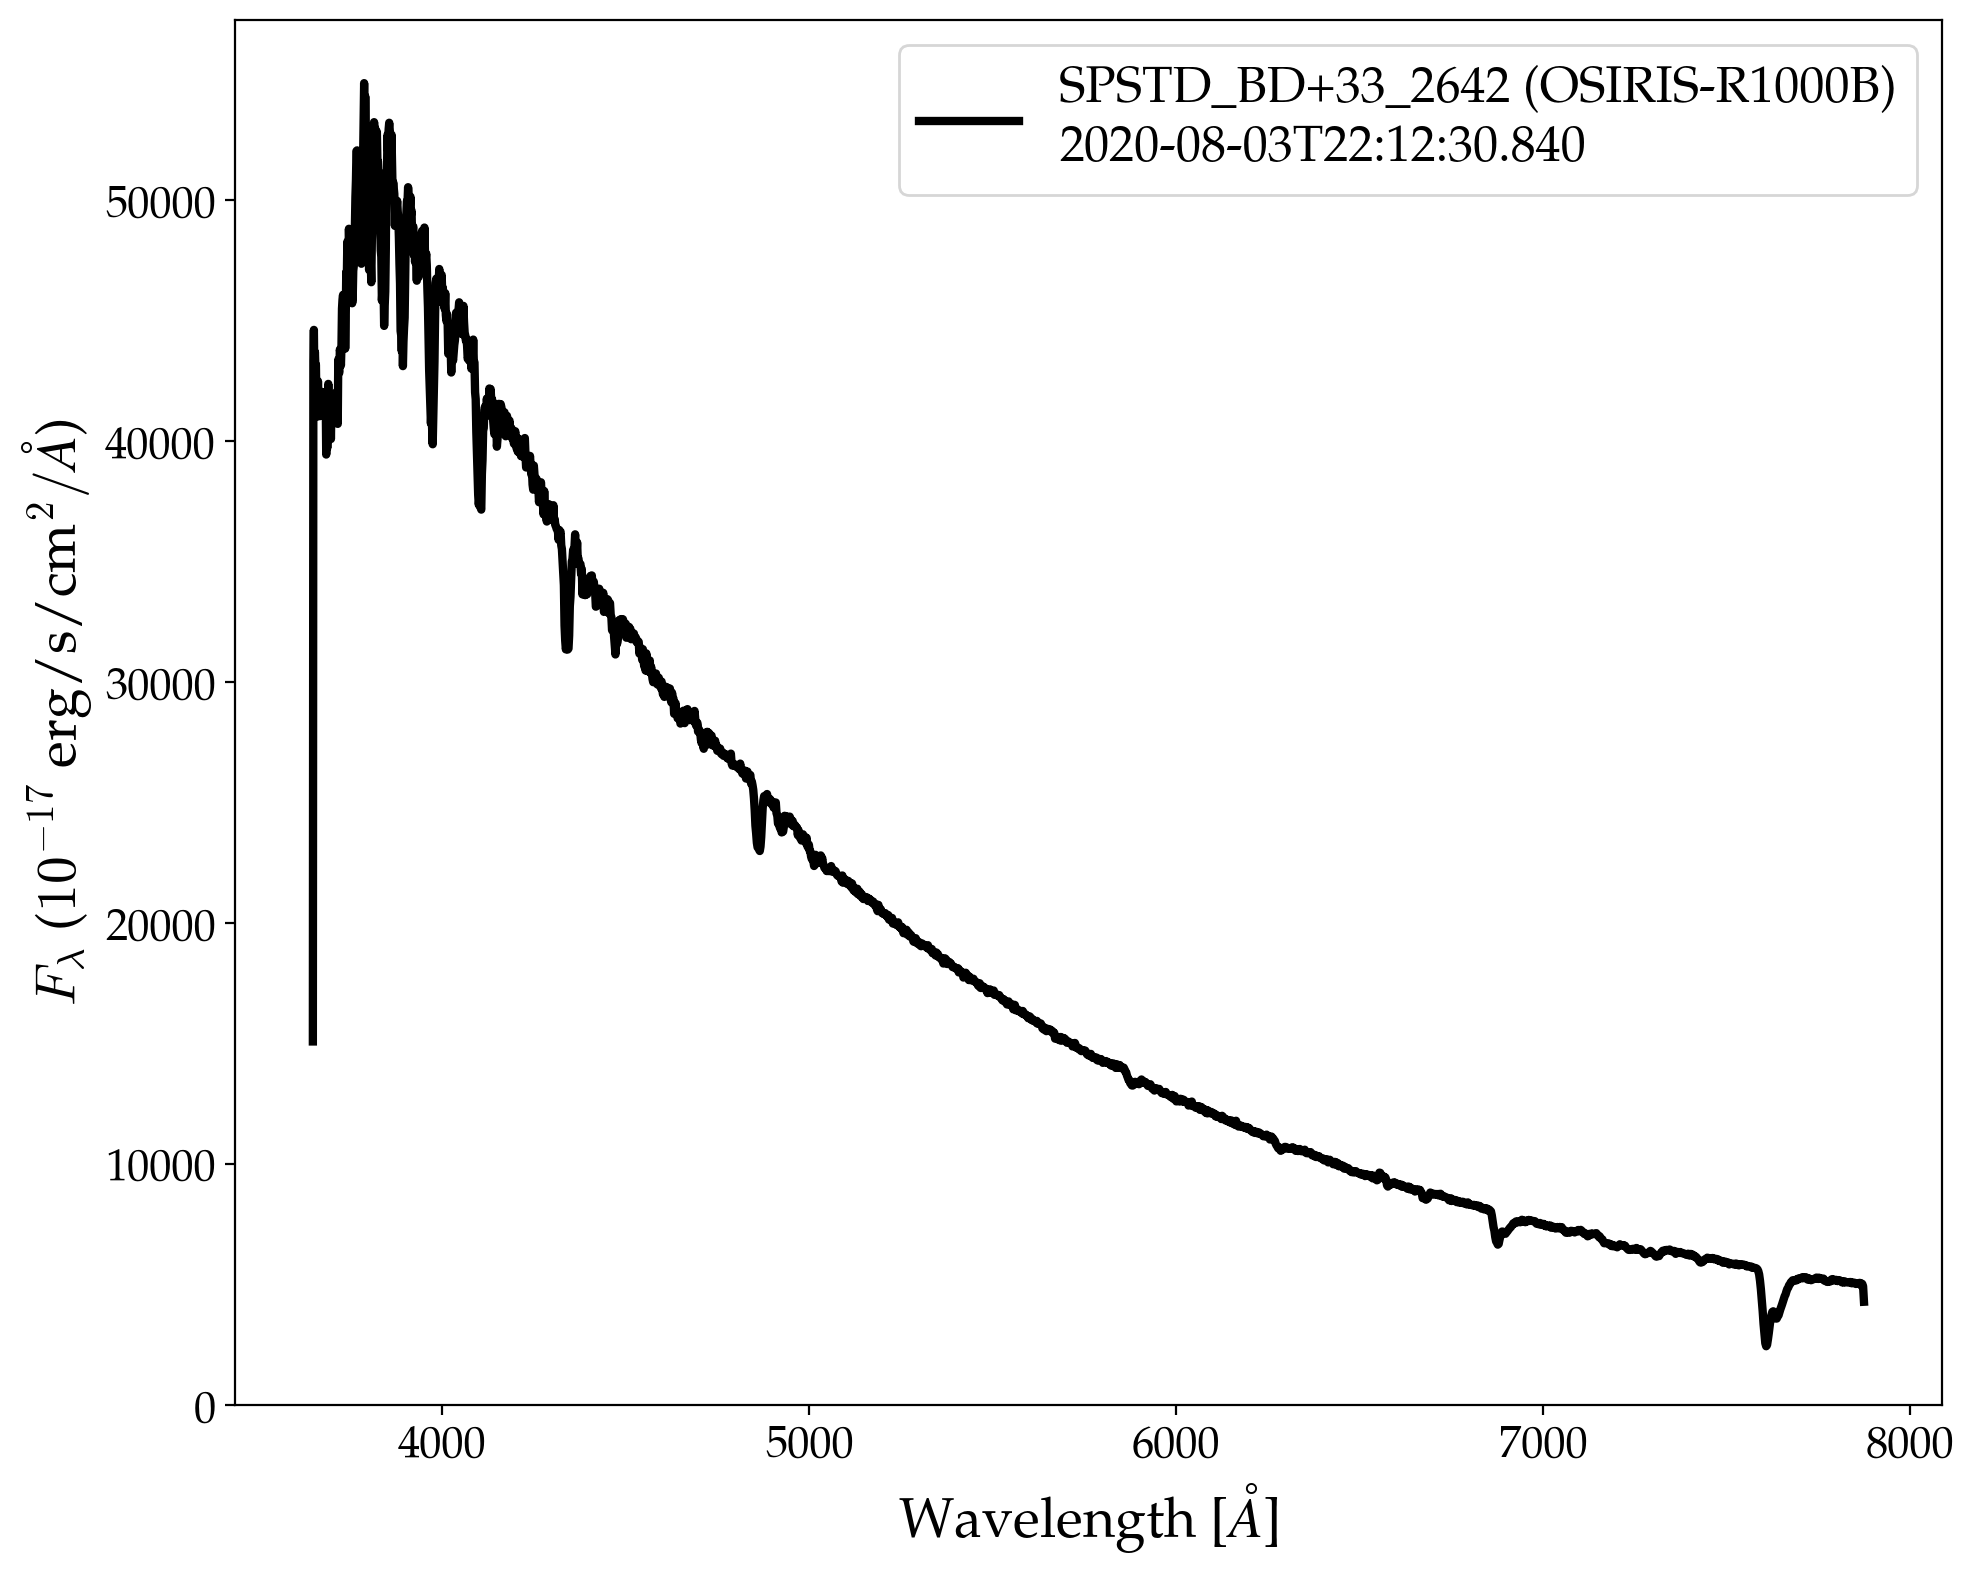

In [62]:
target_index, snr = get_target_index(std_file)
hdu_list = fits.open(std_file)
hdu = hdu_list[target_index]
wave = hdu.data['OPT_WAVE']
flux = hdu.data['OPT_FLAM']

name = hdu_list[0].header["TARGET"]
inst = hdu_list[0].header["INSTRUME"]
grism = hdu_list[0].header["GRISM"]
date = hdu_list[0].header["DATETIME"]
label = f"{name} ({inst}-{grism})\n{date}"

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(wave, flux, lw=3, color='k', label=label)

ax.set_xlabel(r'Wavelength [$\AA$]',fontsize=20)
ax.set_ylabel(r'$F_{\lambda}$ ($10^{-17}$ erg/s/cm$^2/\AA$)',fontsize=20)
ax.tick_params(labelsize=16)
ax.legend(fontsize=18)
ax.set_ylim(0.0, None)
plt.tight_layout()
plt.show()